In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from prophet import Prophet
from scipy import stats
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error


/Users/timhong/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Single Regressor

In [2]:
data = pd.read_excel("owid-covid-data.xlsx")

In [272]:
country_list = [
    'Norway', 'Ireland', 'Lithuania', 'Ireland', 'United Kingdom',
    'Italy', 'Belgium', 'Denmark', 'Switzerland', 'Poland', 'Finland'
]

selected_data = data[data['location'].isin(country_list)]
selected_data.head()



,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
28497,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28498,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28499,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,-151.3,-6.34,-6.34,-13.086293
28500,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28501,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN


In [273]:
data_clean = selected_data[["location", "date", "new_cases"]]
data_clean.head()

,location,date,new_cases
28497,Belgium,2020-01-03,0.0
28498,Belgium,2020-01-04,0.0
28499,Belgium,2020-01-05,0.0
28500,Belgium,2020-01-06,0.0
28501,Belgium,2020-01-07,0.0


## Data Prep

### Dates

In [274]:
# missing values?
missing_values_count_before = data_clean['new_cases'].isnull().sum()
print(missing_values_count_before)


13


In [275]:
# Subset the dataset - 01-30 is the last month with near full observations
data_clean_subset = data_clean[(data_clean['date'] >= '2020-03-01') & (data_clean['date'] <= '2023-01-15')]

In [276]:
# missing values?
missing_values_count_after = data_clean_subset['new_cases'].isnull().sum()
print(missing_values_count_after)

0


### Outliers

Prophet is robust to outliers, so we won't remove them!

In [277]:
cleaned_df = data_clean_subset.copy()

cleaned_df.head()

,location,date,new_cases
28555,Belgium,2020-03-01,0.0
28556,Belgium,2020-03-02,0.0
28557,Belgium,2020-03-03,18.0
28558,Belgium,2020-03-04,19.0
28559,Belgium,2020-03-05,34.0


## Prophet 

In [278]:
# remove location and store it separately
location_names = cleaned_df['location'].unique()

prophet_df = cleaned_df.drop(columns= 'location')
prophet_df.shape



(10510, 2)

Split: 

14/1051 = 0.01332065

1 - 0.01332065 = 0.98667935

### Grid Search to Tune Hyperparameters

In [279]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# Assuming you have a DataFrame data_prepped with a 'new_cases' column, 'date' as the index, and 'location' column
# Make sure 'date' is set as the index

# Define features and target variable
X = cleaned_df.drop('new_cases', axis=1)
y = cleaned_df['new_cases']

# Initialize hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Create an empty DataFrame to store results
initial_results_df = pd.DataFrame(columns=['location', 'initial_rmse'])

# Get unique locations
locations = X['location'].unique()

# Iterate over locations
for location in tqdm(locations, desc="Grid Search Progress"):
    print(f"\nPerforming grid search for location: {location}")

    # Filter data for the current location
    df_location = cleaned_df[cleaned_df['location'] == location].reset_index()

    # Prepare data for Prophet
    df_prophet = df_location[['date', 'new_cases']]
    df_prophet = df_prophet.rename(columns={'date': 'ds', 'new_cases': 'y'})

    # Split the data into training and testing sets
    train_size = int(len(df_prophet) * 0.98667935)
    train_data, test_data = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]

    # Initialize best hyperparameters and RMSE
    best_params = None
    best_rmse = float('inf')

    # Iterate over hyperparameter combinations
    for params in tqdm(list(ParameterGrid(param_grid)), desc="Hyperparameter Search Progress", leave=False):
        # Initialize Prophet model
        prophet_model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            seasonality_mode=params['seasonality_mode']
        )

        # Fit the model
        prophet_model.fit(train_data)

        # Make predictions on the test set
        future = prophet_model.make_future_dataframe(periods=len(test_data))
        forecast = prophet_model.predict(future)

        # Calculate RMSE
        rmse = ((forecast.loc[train_size:, 'yhat'] - test_data['y'])**2).mean()**0.5

        # Update best hyperparameters if RMSE improves
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    print(f"Best hyperparameters for {location}: {best_params}")
    print(f"Best RMSE for {location}: {best_rmse}")

    # Store results in the DataFrame
    initial_results_df = pd.concat([initial_results_df, pd.DataFrame({'location': [location], 'initial_rmse': [best_rmse]})], ignore_index=True)

# Print or save the results DataFrame as needed
initial_results_df


Grid Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Performing grid search for location: Belgium


15:07:37 - cmdstanpy - INFO - Chain [1] start processing
15:07:37 - cmdstanpy - INFO - Chain [1] done processing
15:07:37 - cmdstanpy - INFO - Chain [1] start processing
15:07:37 - cmdstanpy - INFO - Chain [1] done processing
15:07:37 - cmdstanpy - INFO - Chain [1] start processing
15:07:37 - cmdstanpy - INFO - Chain [1] done processing
15:07:37 - cmdstanpy - INFO - Chain [1] start processing
15:07:37 - cmdstanpy - INFO - Chain [1] done processing
15:07:38 - cmdstanpy - INFO - Chain [1] start processing
15:07:38 - cmdstanpy - INFO - Chain [1] done processing
15:07:38 - cmdstanpy - INFO - Chain [1] start processing
15:07:38 - cmdstanpy - INFO - Chain [1] done processing
15:07:38 - cmdstanpy - INFO - Chain [1] start processing
15:07:38 - cmdstanpy - INFO - Chain [1] done processing
15:07:38 - cmdstanpy - INFO - Chain [1] start processing
15:07:39 - cmdstanpy - INFO - Chain [1] done processing
15:07:39 - cmdstanpy - INFO - Chain [1] start processing
15:07:39 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Belgium: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Belgium: 274.6825243302916

Performing grid search for location: Denmark


15:07:54 - cmdstanpy - INFO - Chain [1] start processing
15:07:54 - cmdstanpy - INFO - Chain [1] done processing
15:07:54 - cmdstanpy - INFO - Chain [1] start processing
15:07:54 - cmdstanpy - INFO - Chain [1] done processing
15:07:54 - cmdstanpy - INFO - Chain [1] start processing
15:07:55 - cmdstanpy - INFO - Chain [1] done processing
15:07:55 - cmdstanpy - INFO - Chain [1] start processing
15:07:55 - cmdstanpy - INFO - Chain [1] done processing
15:07:55 - cmdstanpy - INFO - Chain [1] start processing
15:07:55 - cmdstanpy - INFO - Chain [1] done processing
15:07:55 - cmdstanpy - INFO - Chain [1] start processing
15:07:55 - cmdstanpy - INFO - Chain [1] done processing
15:07:55 - cmdstanpy - INFO - Chain [1] start processing
15:07:55 - cmdstanpy - INFO - Chain [1] done processing
15:07:56 - cmdstanpy - INFO - Chain [1] start processing
15:07:56 - cmdstanpy - INFO - Chain [1] done processing
15:07:56 - cmdstanpy - INFO - Chain [1] start processing
15:07:56 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Denmark: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Denmark: 431.2971569737247

Performing grid search for location: Finland


15:08:14 - cmdstanpy - INFO - Chain [1] start processing
15:08:14 - cmdstanpy - INFO - Chain [1] done processing
15:08:14 - cmdstanpy - INFO - Chain [1] start processing
15:08:14 - cmdstanpy - INFO - Chain [1] done processing
15:08:15 - cmdstanpy - INFO - Chain [1] start processing
15:08:15 - cmdstanpy - INFO - Chain [1] done processing
15:08:15 - cmdstanpy - INFO - Chain [1] start processing
15:08:15 - cmdstanpy - INFO - Chain [1] done processing
15:08:15 - cmdstanpy - INFO - Chain [1] start processing
15:08:15 - cmdstanpy - INFO - Chain [1] done processing
15:08:15 - cmdstanpy - INFO - Chain [1] start processing
15:08:15 - cmdstanpy - INFO - Chain [1] done processing
15:08:16 - cmdstanpy - INFO - Chain [1] start processing
15:08:16 - cmdstanpy - INFO - Chain [1] done processing
15:08:16 - cmdstanpy - INFO - Chain [1] start processing
15:08:16 - cmdstanpy - INFO - Chain [1] done processing
15:08:16 - cmdstanpy - INFO - Chain [1] start processing
15:08:16 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Finland: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
Best RMSE for Finland: 393.54800662195623

Performing grid search for location: Ireland


15:08:31 - cmdstanpy - INFO - Chain [1] start processing
15:08:31 - cmdstanpy - INFO - Chain [1] done processing
15:08:31 - cmdstanpy - INFO - Chain [1] start processing
15:08:31 - cmdstanpy - INFO - Chain [1] done processing
15:08:32 - cmdstanpy - INFO - Chain [1] start processing
15:08:32 - cmdstanpy - INFO - Chain [1] done processing
15:08:32 - cmdstanpy - INFO - Chain [1] start processing
15:08:32 - cmdstanpy - INFO - Chain [1] done processing
15:08:32 - cmdstanpy - INFO - Chain [1] start processing
15:08:32 - cmdstanpy - INFO - Chain [1] done processing
15:08:32 - cmdstanpy - INFO - Chain [1] start processing
15:08:32 - cmdstanpy - INFO - Chain [1] done processing
15:08:33 - cmdstanpy - INFO - Chain [1] start processing
15:08:33 - cmdstanpy - INFO - Chain [1] done processing
15:08:33 - cmdstanpy - INFO - Chain [1] start processing
15:08:33 - cmdstanpy - INFO - Chain [1] done processing
15:08:33 - cmdstanpy - INFO - Chain [1] start processing
15:08:33 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Ireland: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for Ireland: 334.37502327653664

Performing grid search for location: Italy


15:08:48 - cmdstanpy - INFO - Chain [1] start processing
15:08:48 - cmdstanpy - INFO - Chain [1] done processing
15:08:48 - cmdstanpy - INFO - Chain [1] start processing
15:08:48 - cmdstanpy - INFO - Chain [1] done processing
15:08:48 - cmdstanpy - INFO - Chain [1] start processing
15:08:49 - cmdstanpy - INFO - Chain [1] done processing
15:08:49 - cmdstanpy - INFO - Chain [1] start processing
15:08:49 - cmdstanpy - INFO - Chain [1] done processing
15:08:49 - cmdstanpy - INFO - Chain [1] start processing
15:08:49 - cmdstanpy - INFO - Chain [1] done processing
15:08:49 - cmdstanpy - INFO - Chain [1] start processing
15:08:49 - cmdstanpy - INFO - Chain [1] done processing
15:08:50 - cmdstanpy - INFO - Chain [1] start processing
15:08:50 - cmdstanpy - INFO - Chain [1] done processing
15:08:50 - cmdstanpy - INFO - Chain [1] start processing
15:08:50 - cmdstanpy - INFO - Chain [1] done processing
15:08:50 - cmdstanpy - INFO - Chain [1] start processing
15:08:50 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Italy: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE for Italy: 14449.972939519403

Performing grid search for location: Lithuania


15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] done processing
15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] done processing
15:09:05 - cmdstanpy - INFO - Chain [1] start processing
15:09:05 - cmdstanpy - INFO - Chain [1] done processing
15:09:05 - cmdstanpy - INFO - Chain [1] start processing
15:09:05 - cmdstanpy - INFO - Chain [1] done processing
15:09:05 - cmdstanpy - INFO - Chain [1] start processing
15:09:05 - cmdstanpy - INFO - Chain [1] done processing
15:09:05 - cmdstanpy - INFO - Chain [1] start processing
15:09:05 - cmdstanpy - INFO - Chain [1] done processing
15:09:06 - cmdstanpy - INFO - Chain [1] start processing
15:09:06 - cmdstanpy - INFO - Chain [1] done processing
15:09:06 - cmdstanpy - INFO - Chain [1] start processing
15:09:06 - cmdstanpy - INFO - Chain [1] done processing
15:09:06 - cmdstanpy - INFO - Chain [1] start processing
15:09:06 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Lithuania: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for Lithuania: 201.431561687187

Performing grid search for location: Norway


15:09:23 - cmdstanpy - INFO - Chain [1] start processing
15:09:23 - cmdstanpy - INFO - Chain [1] done processing
15:09:23 - cmdstanpy - INFO - Chain [1] start processing
15:09:23 - cmdstanpy - INFO - Chain [1] done processing
15:09:23 - cmdstanpy - INFO - Chain [1] start processing
15:09:23 - cmdstanpy - INFO - Chain [1] done processing
15:09:23 - cmdstanpy - INFO - Chain [1] start processing
15:09:23 - cmdstanpy - INFO - Chain [1] done processing
15:09:24 - cmdstanpy - INFO - Chain [1] start processing
15:09:24 - cmdstanpy - INFO - Chain [1] done processing
15:09:24 - cmdstanpy - INFO - Chain [1] start processing
15:09:24 - cmdstanpy - INFO - Chain [1] done processing
15:09:24 - cmdstanpy - INFO - Chain [1] start processing
15:09:24 - cmdstanpy - INFO - Chain [1] done processing
15:09:24 - cmdstanpy - INFO - Chain [1] start processing
15:09:24 - cmdstanpy - INFO - Chain [1] done processing
15:09:25 - cmdstanpy - INFO - Chain [1] start processing
15:09:25 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Norway: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for Norway: 86.41069450243329

Performing grid search for location: Poland


15:09:42 - cmdstanpy - INFO - Chain [1] start processing
15:09:42 - cmdstanpy - INFO - Chain [1] done processing
15:09:42 - cmdstanpy - INFO - Chain [1] start processing
15:09:42 - cmdstanpy - INFO - Chain [1] done processing
15:09:43 - cmdstanpy - INFO - Chain [1] start processing
15:09:43 - cmdstanpy - INFO - Chain [1] done processing
15:09:43 - cmdstanpy - INFO - Chain [1] start processing
15:09:43 - cmdstanpy - INFO - Chain [1] done processing
15:09:43 - cmdstanpy - INFO - Chain [1] start processing
15:09:43 - cmdstanpy - INFO - Chain [1] done processing
15:09:43 - cmdstanpy - INFO - Chain [1] start processing
15:09:43 - cmdstanpy - INFO - Chain [1] done processing
15:09:44 - cmdstanpy - INFO - Chain [1] start processing
15:09:44 - cmdstanpy - INFO - Chain [1] done processing
15:09:44 - cmdstanpy - INFO - Chain [1] start processing
15:09:44 - cmdstanpy - INFO - Chain [1] done processing
15:09:44 - cmdstanpy - INFO - Chain [1] start processing
15:09:44 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Poland: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Best RMSE for Poland: 239.50530492040173

Performing grid search for location: Switzerland


15:10:00 - cmdstanpy - INFO - Chain [1] start processing
15:10:00 - cmdstanpy - INFO - Chain [1] done processing
15:10:00 - cmdstanpy - INFO - Chain [1] start processing
15:10:00 - cmdstanpy - INFO - Chain [1] done processing
15:10:00 - cmdstanpy - INFO - Chain [1] start processing
15:10:00 - cmdstanpy - INFO - Chain [1] done processing
15:10:01 - cmdstanpy - INFO - Chain [1] start processing
15:10:01 - cmdstanpy - INFO - Chain [1] done processing
15:10:01 - cmdstanpy - INFO - Chain [1] start processing
15:10:01 - cmdstanpy - INFO - Chain [1] done processing
15:10:01 - cmdstanpy - INFO - Chain [1] start processing
15:10:01 - cmdstanpy - INFO - Chain [1] done processing
15:10:01 - cmdstanpy - INFO - Chain [1] start processing
15:10:01 - cmdstanpy - INFO - Chain [1] done processing
15:10:02 - cmdstanpy - INFO - Chain [1] start processing
15:10:02 - cmdstanpy - INFO - Chain [1] done processing
15:10:02 - cmdstanpy - INFO - Chain [1] start processing
15:10:02 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for Switzerland: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
Best RMSE for Switzerland: 2393.0714510186704

Performing grid search for location: United Kingdom


15:10:17 - cmdstanpy - INFO - Chain [1] start processing
15:10:17 - cmdstanpy - INFO - Chain [1] done processing
15:10:18 - cmdstanpy - INFO - Chain [1] start processing
15:10:18 - cmdstanpy - INFO - Chain [1] done processing
15:10:18 - cmdstanpy - INFO - Chain [1] start processing
15:10:18 - cmdstanpy - INFO - Chain [1] done processing
15:10:18 - cmdstanpy - INFO - Chain [1] start processing
15:10:18 - cmdstanpy - INFO - Chain [1] done processing
15:10:18 - cmdstanpy - INFO - Chain [1] start processing
15:10:18 - cmdstanpy - INFO - Chain [1] done processing
15:10:19 - cmdstanpy - INFO - Chain [1] start processing
15:10:19 - cmdstanpy - INFO - Chain [1] done processing
15:10:19 - cmdstanpy - INFO - Chain [1] start processing
15:10:19 - cmdstanpy - INFO - Chain [1] done processing
15:10:19 - cmdstanpy - INFO - Chain [1] start processing
15:10:19 - cmdstanpy - INFO - Chain [1] done processing
15:10:19 - cmdstanpy - INFO - Chain [1] start processing
15:10:20 - cmdstanpy - INFO - Chain [1]

Best hyperparameters for United Kingdom: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
Best RMSE for United Kingdom: 587.7879382197458


,location,initial_rmse
0,Belgium,274.682524
1,Denmark,431.297157
2,Finland,393.548007
3,Ireland,334.375023
4,Italy,14449.972940
5,Lithuania,201.431562
6,Norway,86.410695
7,Poland,239.505305
8,Switzerland,2393.071451
9,United Kingdom,587.787938


In [308]:
## Storing params
belgium_params = {
    'changepoint_prior_scale': 0.1,
    'seasonality_mode': 'multiplicative',
    'seasonality_prior_scale': 0.01
}
denmark_params = {'changepoint_prior_scale': 0.1,
                  'seasonality_mode': 'multiplicative', 
                  'seasonality_prior_scale': 0.01}

finland_params = {'changepoint_prior_scale': 0.1,
                  'seasonality_mode': 'multiplicative', 
                  'seasonality_prior_scale': 1.0}

ireland_params = {'changepoint_prior_scale': 0.1,
                  'seasonality_mode': 'multiplicative', 
                  'seasonality_prior_scale': 0.1}

italy_params = {'changepoint_prior_scale': 0.1,
                'seasonality_mode': 'multiplicative', 
                'seasonality_prior_scale': 0.01}

lithuania_params = {'changepoint_prior_scale': 0.01,
                    'seasonality_mode': 'multiplicative', 
                    'seasonality_prior_scale': 0.1}

norway_params = {'changepoint_prior_scale': 0.1,
                 'seasonality_mode': 'multiplicative', 
                 'seasonality_prior_scale': 0.1}

poland_params = {'changepoint_prior_scale': 0.1, 
                 'seasonality_mode': 'multiplicative', 
                 'seasonality_prior_scale': 0.1}

swiss_params = {'changepoint_prior_scale': 0.1, 
                'seasonality_mode': 'multiplicative', 
                'seasonality_prior_scale': 1.0}

uk_params = {'changepoint_prior_scale': 0.1, 
             'seasonality_mode': 'multiplicative', 
             'seasonality_prior_scale': 1.0}



## Adding National Holidays and COVID Lockdown Dates
I want to use the holidays feature of prophet to add 1). National Holidays, and 2). important lockdown-related dates, by country. I will add these lockdown dates as one-off (non-recurring) holidays!

### Defining Lockdown Dates

In [281]:
# Belgium
belgium_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-20', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-06', 'lower_window': 0, 'ds_upper': '2021-04-26'}
])
for t_col in ['ds', 'ds_upper']:
    belgium_lockdowns[t_col] = pd.to_datetime(belgium_lockdowns[t_col])
belgium_lockdowns['upper_window'] = (belgium_lockdowns['ds_upper'] - belgium_lockdowns['ds']).dt.days

# Denmark - strict and fast
denmark_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-04-15'}
])
for t_col in ['ds', 'ds_upper']:
    denmark_lockdowns[t_col] = pd.to_datetime(denmark_lockdowns[t_col])
denmark_lockdowns['upper_window'] = (denmark_lockdowns['ds_upper'] - denmark_lockdowns['ds']).dt.days

# Finland
finland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2021-03-08', 'lower_window': 0, 'ds_upper': '2021-03-30'}
])
for t_col in ['ds', 'ds_upper']:
    finland_lockdowns[t_col] = pd.to_datetime(finland_lockdowns[t_col])
finland_lockdowns['upper_window'] = (finland_lockdowns['ds_upper'] - finland_lockdowns['ds']).dt.days

# Ireland
ireland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2021-01-26', 'lower_window': 0, 'ds_upper': '2021-03-19'}
])
for t_col in ['ds', 'ds_upper']:
    ireland_lockdowns[t_col] = pd.to_datetime(ireland_lockdowns[t_col])
ireland_lockdowns['upper_window'] = (ireland_lockdowns['ds_upper'] - ireland_lockdowns['ds']).dt.days

# Italy
italy_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-08', 'lower_window': 0, 'ds_upper': '2020-05-04'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-04', 'lower_window': 0, 'ds_upper': '2021-01-06'}
])
for t_col in ['ds', 'ds_upper']:
    italy_lockdowns[t_col] = pd.to_datetime(italy_lockdowns[t_col])
italy_lockdowns['upper_window'] = (italy_lockdowns['ds_upper'] - italy_lockdowns['ds']).dt.days

# Lithuania
lithuania_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-04-16'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-07', 'lower_window': 0, 'ds_upper': '2021-12-31'}
])
for t_col in ['ds', 'ds_upper']:
    lithuania_lockdowns[t_col] = pd.to_datetime(lithuania_lockdowns[t_col])
lithuania_lockdowns['upper_window'] = (lithuania_lockdowns['ds_upper'] - lithuania_lockdowns['ds']).dt.days

# Norway
norway_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-05-08'}
])
for t_col in ['ds', 'ds_upper']:
    norway_lockdowns[t_col] = pd.to_datetime(norway_lockdowns[t_col])
norway_lockdowns['upper_window'] = (norway_lockdowns['ds_upper'] - norway_lockdowns['ds']).dt.days

# Poland
poland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-12-28', 'lower_window': 0, 'ds_upper': '2021-01-31'},
    {'holiday': 'lockdown_3', 'ds': '2021-03-11', 'lower_window': 0, 'ds_upper': '2021-04-28'}
])
for t_col in ['ds', 'ds_upper']:
    poland_lockdowns[t_col] = pd.to_datetime(poland_lockdowns[t_col])
poland_lockdowns['upper_window'] = (poland_lockdowns['ds_upper'] - poland_lockdowns['ds']).dt.days

# Switzerland
swiss_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-01', 'lower_window': 0, 'ds_upper': '2021-09-21'},
    {'holiday': 'lockdown_3', 'ds': '2021-12-01', 'lower_window': 0, 'ds_upper': '2022-02-17'}
])
for t_col in ['ds', 'ds_upper']:
    swiss_lockdowns[t_col] = pd.to_datetime(swiss_lockdowns[t_col])
swiss_lockdowns['upper_window'] = (swiss_lockdowns['ds_upper'] - swiss_lockdowns['ds']).dt.days

# United Kingdom
uk_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-06-01'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-05', 'lower_window': 0, 'ds_upper': '2020-12-02'},
    {'holiday': 'lockdown_3', 'ds': '2021-01-06', 'lower_window': 0, 'ds_upper': '2022-03-08'}
])
for t_col in ['ds', 'ds_upper']:
    uk_lockdowns[t_col] = pd.to_datetime(uk_lockdowns[t_col])
uk_lockdowns['upper_window'] = (uk_lockdowns['ds_upper'] - uk_lockdowns['ds']).dt.days

For national holidays, I will specify.

## Fitting Models to Each Country

In [309]:
# renaming variables & splitting into separate datasets by country
prophet_df_og = cleaned_df.rename(columns={'date': 'ds', 'new_cases': 'y'})

prophet_df = prophet_df_og.copy()
# Convert location to lowercase
prophet_df['location'] = prophet_df['location'].str.lower()

# Initialize variables for each location DataFrame
belgium_df = pd.DataFrame()
denmark_df = pd.DataFrame()
finland_df = pd.DataFrame()
ireland_df = pd.DataFrame()
italy_df = pd.DataFrame()
lithuania_df = pd.DataFrame()
norway_df = pd.DataFrame()
poland_df = pd.DataFrame()
switzerland_df = pd.DataFrame()
united_kingdom_df = pd.DataFrame()

# Iterate through unique locations and assign the data to respective DataFrames
for location in prophet_df['location'].unique():
    current_location_df = prophet_df[prophet_df['location'] == location].copy()
    # Assign the data to the respective DataFrame variable
    globals()[f"{location}_df"] = current_location_df

# Now you can access each DataFrame by its variable name, for example, belgium_df, denmark_df, etc.



In [310]:
uk_df = prophet_df_og[prophet_df_og['location'] == 'United Kingdom']
uk_df.head()



,location,ds,y
321453,United Kingdom,2020-03-01,12.0
321454,United Kingdom,2020-03-02,4.0
321455,United Kingdom,2020-03-03,20.0
321456,United Kingdom,2020-03-04,41.0
321457,United Kingdom,2020-03-05,58.0


In [311]:
finland_df.head()

,location,ds,y
101728,finland,2020-03-01,3.0
101729,finland,2020-03-02,1.0
101730,finland,2020-03-03,1.0
101731,finland,2020-03-04,0.0
101732,finland,2020-03-05,4.0


In [312]:
split_index = int(len(belgium_df) * 0.98667935)
## setting train/test splits for each country
# Drop the 'location' column from the Belgium DataFrame and split into training and testing sets
belgium_df = belgium_df.drop('location', axis=1)
train_belgium = belgium_df.iloc[:split_index]
test_belgium = belgium_df.iloc[split_index:]

# Drop the 'location' column from the Denmark DataFrame and split into training and testing sets
denmark_df = denmark_df.drop('location', axis=1)
train_denmark = denmark_df.iloc[:split_index]
test_denmark = denmark_df.iloc[split_index:]

# Drop the 'location' column from the Finland DataFrame and split into training and testing sets
finland_df = finland_df.drop('location', axis=1)
train_finland = finland_df.iloc[:split_index]
test_finland = finland_df.iloc[split_index:]

# Drop the 'location' column from the Ireland DataFrame and split into training and testing sets
ireland_df = ireland_df.drop('location', axis=1)
train_ireland = ireland_df.iloc[:split_index]
test_ireland = ireland_df.iloc[split_index:]

# Drop the 'location' column from the Italy DataFrame and split into training and testing sets
italy_df = italy_df.drop('location', axis=1)
train_italy = italy_df.iloc[:split_index]
test_italy = italy_df.iloc[split_index:]

# Drop the 'location' column from the Lithuania DataFrame and split into training and testing sets
lithuania_df = lithuania_df.drop('location', axis=1)
train_lithuania = lithuania_df.iloc[:split_index]
test_lithuania = lithuania_df.iloc[split_index:]

# Drop the 'location' column from the Norway DataFrame and split into training and testing sets
norway_df = norway_df.drop('location', axis=1)
train_norway = norway_df.iloc[:split_index]
test_norway = norway_df.iloc[split_index:]

# Drop the 'location' column from the Poland DataFrame and split into training and testing sets
poland_df = poland_df.drop('location', axis=1)
train_poland = poland_df.iloc[:split_index]
test_poland = poland_df.iloc[split_index:]

# Drop the 'location' column from the Switzerland DataFrame and split into training and testing sets
switzerland_df = switzerland_df.drop('location', axis=1)
train_switzerland = switzerland_df.iloc[:split_index]
test_switzerland = switzerland_df.iloc[split_index:]

# Drop the 'location' column from the United Kingdom DataFrame and split into training and testing sets
uk_df = uk_df.drop('location', axis=1)
train_uk = uk_df.iloc[:split_index]
test_uk = uk_df.iloc[split_index:]


In [286]:
initial_results_df

,location,initial_rmse
0,Belgium,274.682524
1,Denmark,431.297157
2,Finland,393.548007
3,Ireland,334.375023
4,Italy,14449.972940
5,Lithuania,201.431562
6,Norway,86.410695
7,Poland,239.505305
8,Switzerland,2393.071451
9,United Kingdom,587.787938


Having looked at the optimally tuned parameters, I realized that the holidays_prior_scale was set to 0.01 for all models. THis makes sense, as no holidays had been introduced yet. Thus, between the initial model and the model with holidays added, I changed the holidays_prior_scale from the default (initial) to holidays_prior_scale = 5. This would place weight on the newly added holidays and lockdowns and examine their effect on RMSE.

In [372]:
## Adding Results DF
country_names = ['Belgium', 'Denmark', 'Finland', 'Ireland', 'Italy', 
                 'Lithuania', 'Norway', 'Poland', 'Switzerland', 'United Kingdom'] 

initial_train_rmse = list([])
initial_test_rmse = list([])
final_train_rmse = list([])
final_test_rmse = list([])
standardized_rmse = list([])

### 1. Belgium

#### Initial

15:39:23 - cmdstanpy - INFO - Chain [1] start processing


15:39:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3369632570.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_belgium['ds'] = pd.to_datetime(train_belgium['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3369632570.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_belgium['ds'] = pd.to_datetime(test_belgium['ds'])


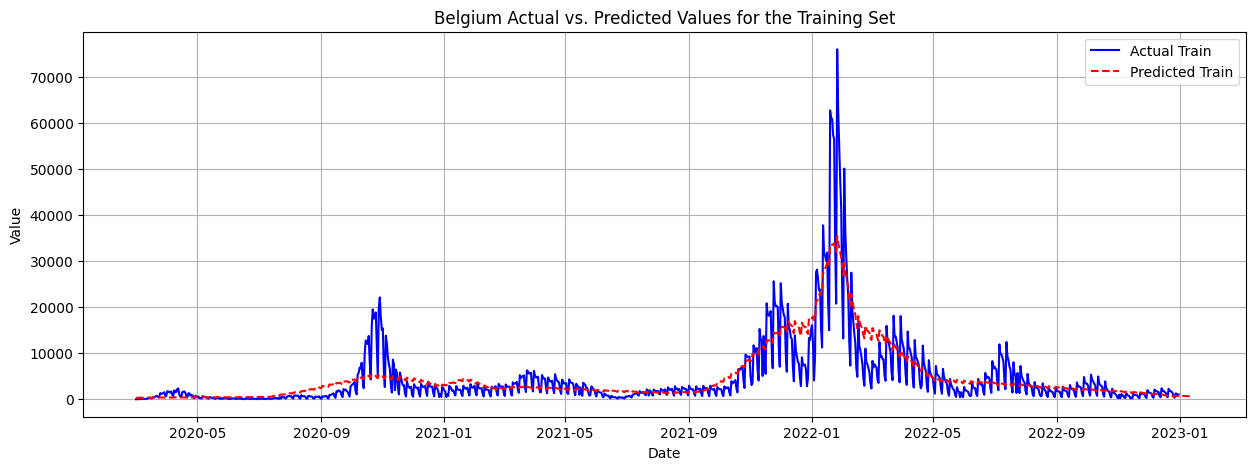

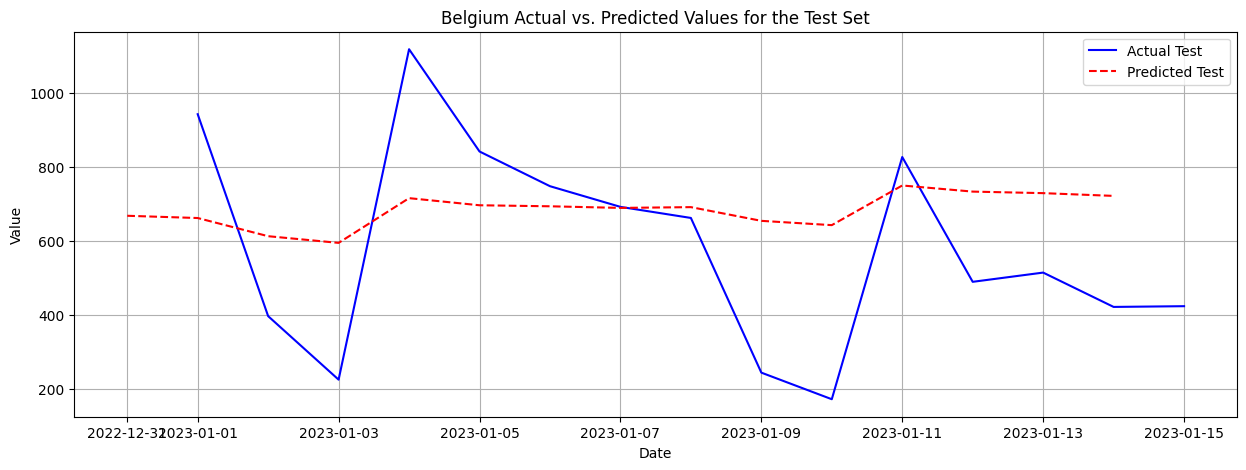

RMSE for the training set: 4110.32682815228
RMSE for the test set: 301.18296072164617
sRMSE for the training set: 90.89406107161155
sRMSE for the test set: 51.84466847400382


In [373]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(**belgium_params)
# adding swiss holidays
m.fit(train_belgium)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_belgium['ds'] = pd.to_datetime(train_belgium['ds'])
test_belgium['ds'] = pd.to_datetime(test_belgium['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_belgium['ds'], train_belgium['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Belgium Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_belgium['ds'], test_belgium['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_belgium)), forecast['yhat'].tail(len(test_belgium)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Belgium Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_belgium['y'].values
predicted_train_values = forecast['yhat'].head(len(train_belgium)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_belgium['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_belgium)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

initial_train_rmse.append(rmse_train)
initial_test_rmse.append(rmse_test)




#### Post Holidays

15:39:24 - cmdstanpy - INFO - Chain [1] start processing
15:39:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3739943405.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_belgium['ds'] = pd.to_datetime(train_belgium['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3739943405.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_belgium['ds'] = pd.to_datetime(test_belgium['ds'])


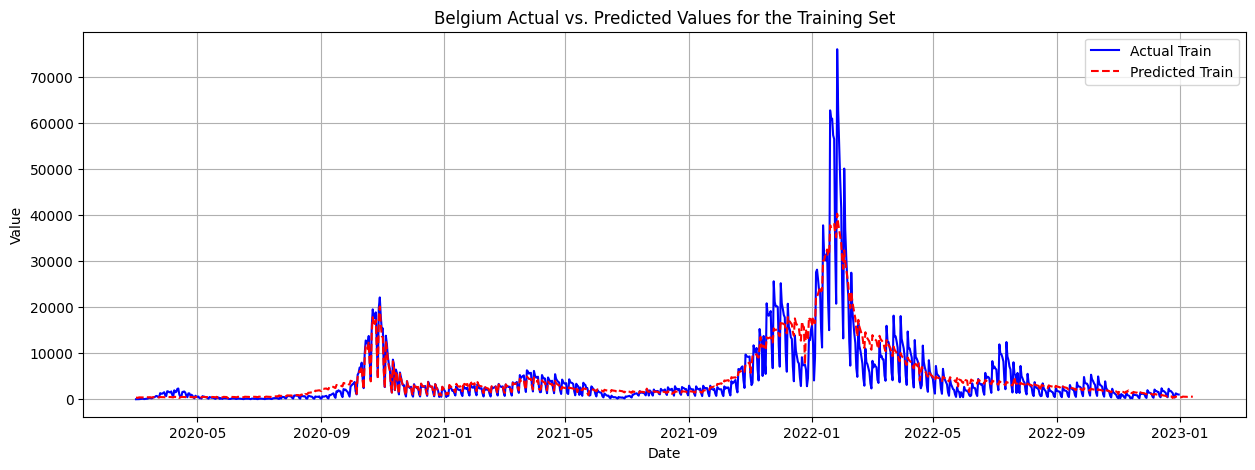

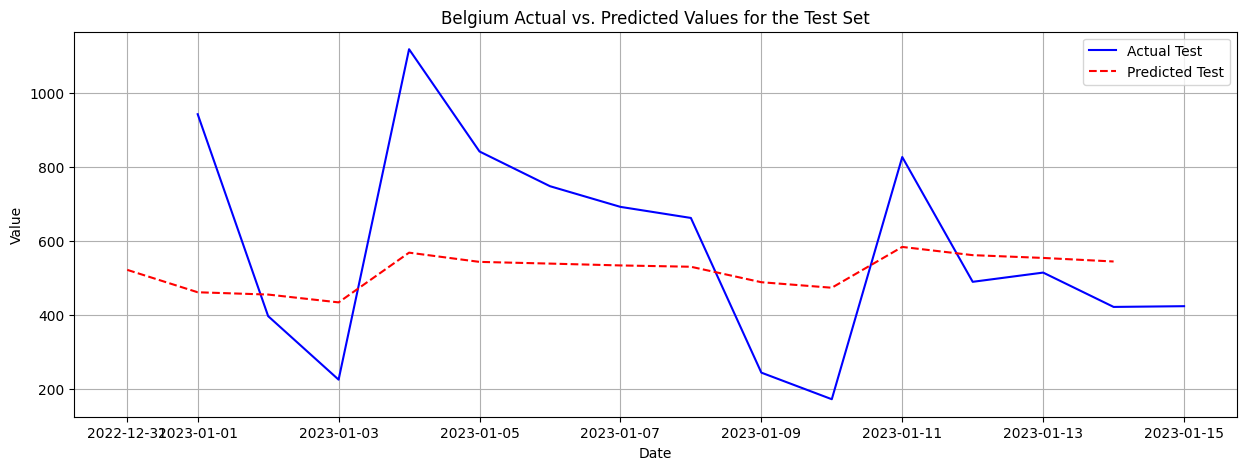

RMSE for the training set: 3371.1763688531414
RMSE for the test set: 284.4820693473135
sRMSE for the training set: 74.54879467369663
sRMSE for the test set: 48.969830619803794


In [374]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays = belgium_lockdowns,**belgium_params, holidays_prior_scale = 20)
# adding swiss holidays
m.add_country_holidays(country_name='Belgium')
m.fit(train_belgium)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_belgium['ds'] = pd.to_datetime(train_belgium['ds'])
test_belgium['ds'] = pd.to_datetime(test_belgium['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_belgium['ds'], train_belgium['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Belgium Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_belgium['ds'], test_belgium['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_belgium)), forecast['yhat'].tail(len(test_belgium)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Belgium Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_belgium['y'].values
predicted_train_values = forecast['yhat'].head(len(train_belgium)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_belgium['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_belgium)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)





### 2. Denmark

#### Initial

15:39:25 - cmdstanpy - INFO - Chain [1] start processing
15:39:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/70474580.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_denmark['ds'] = pd.to_datetime(train_denmark['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/70474580.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_denmark['ds'] = pd.to_datetime(test_denmark['ds'])


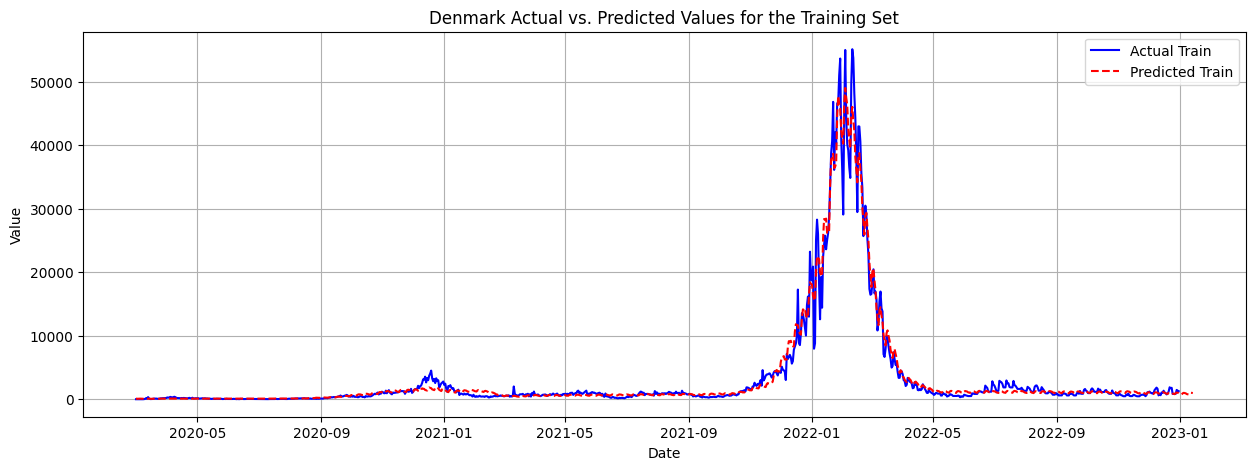

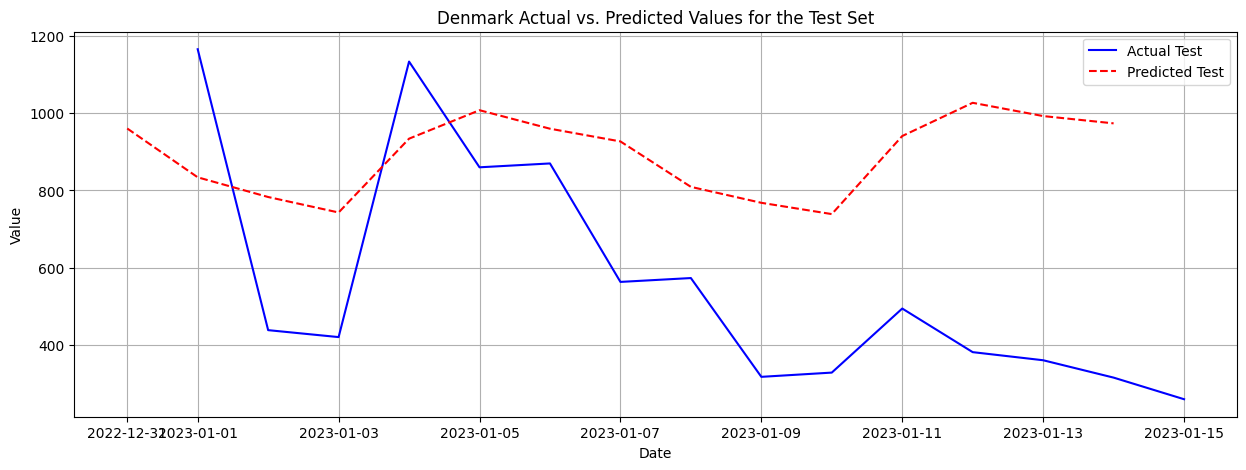

RMSE for the training set: 1293.3945624541166
RMSE for the test set: 448.4295063671323
sRMSE for the training set: 39.544969295659676
sRMSE for the test set: 79.33996927939354


In [375]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(**denmark_params)
# adding swiss holidays
m.fit(train_denmark)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_denmark['ds'] = pd.to_datetime(train_denmark['ds'])
test_denmark['ds'] = pd.to_datetime(test_denmark['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_denmark['ds'], train_denmark['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Denmark Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_denmark['ds'], test_denmark['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_denmark)), forecast['yhat'].tail(len(test_denmark)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Denmark Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_denmark['y'].values
predicted_train_values = forecast['yhat'].head(len(train_denmark)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_denmark['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_denmark)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

initial_train_rmse.append(rmse_train)
initial_test_rmse.append(rmse_test)



#### Final

15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/2236349411.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_denmark['ds'] = pd.to_datetime(train_denmark['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/2236349411.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_denmark['ds'] = pd.to_datetime(test_denmark['ds'])


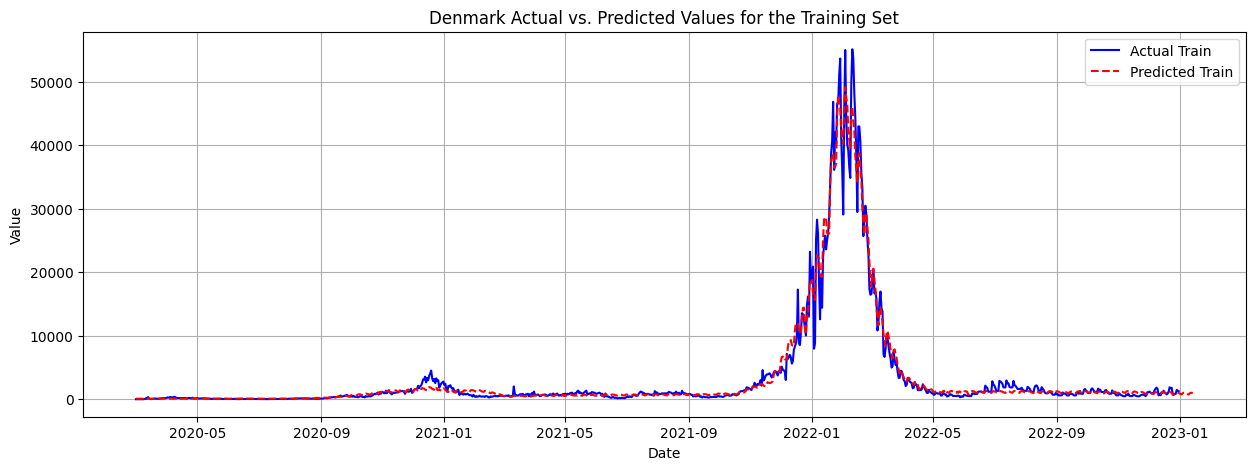

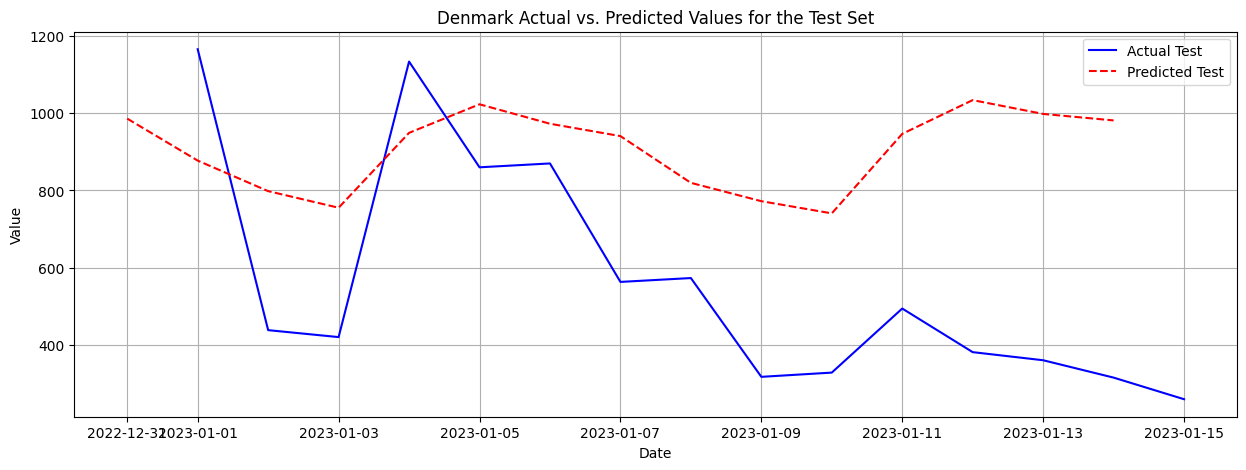

RMSE for the training set: 1280.0497888819614
RMSE for the test set: 456.1412430126489
sRMSE for the training set: 39.13695871908271
sRMSE for the test set: 80.7043954374821


In [376]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=denmark_lockdowns, **denmark_params, holidays_prior_scale = 2)
m.add_country_holidays(country_name='Denmark')
m.fit(train_denmark)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_denmark['ds'] = pd.to_datetime(train_denmark['ds'])
test_denmark['ds'] = pd.to_datetime(test_denmark['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_denmark['ds'], train_denmark['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Denmark Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_denmark['ds'], test_denmark['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_denmark)), forecast['yhat'].tail(len(test_denmark)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Denmark Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_denmark['y'].values
predicted_train_values = forecast['yhat'].head(len(train_denmark)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_denmark['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_denmark)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 3. Finland

#### Initial

15:39:27 - cmdstanpy - INFO - Chain [1] start processing


15:39:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/774814257.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_finland['ds'] = pd.to_datetime(train_finland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/774814257.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_finland['ds'] = pd.to_datetime(test_finland['ds'])


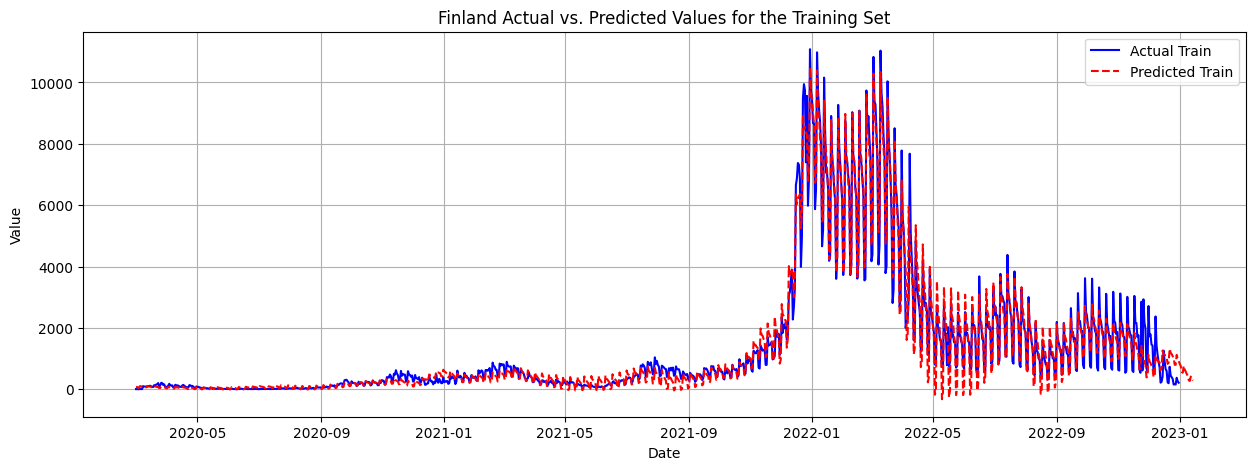

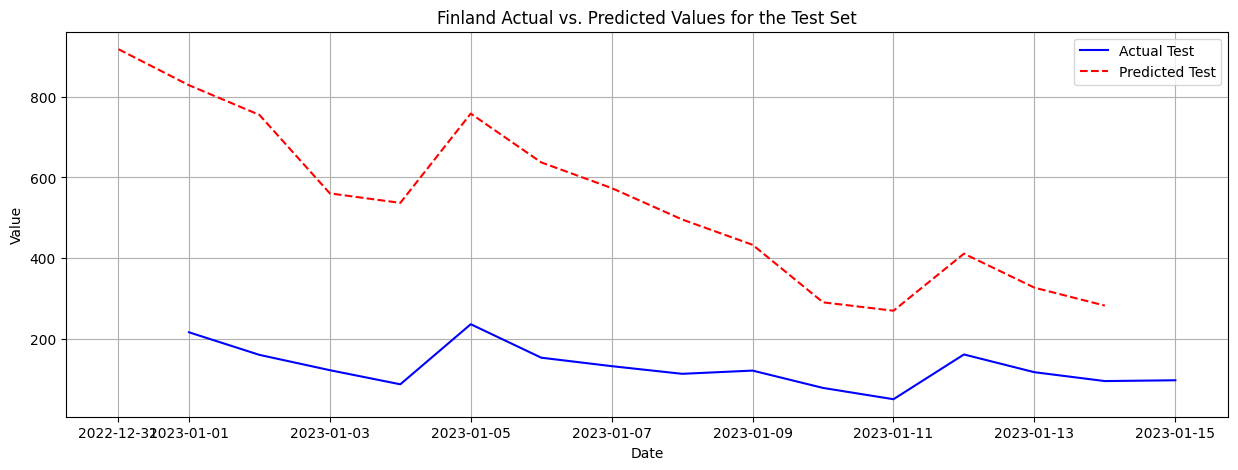

RMSE for the training set: 365.0780786672954
RMSE for the test set: 447.1917550424413
sRMSE for the training set: 25.94815933974556
sRMSE for the test set: 346.1236494136543


In [377]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(**finland_params)
# adding swiss holidays
m.fit(train_finland)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_finland['ds'] = pd.to_datetime(train_finland['ds'])
test_finland['ds'] = pd.to_datetime(test_finland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_finland['ds'], train_finland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Finland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_finland['ds'], test_finland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_finland)), forecast['yhat'].tail(len(test_finland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Finland Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_finland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_finland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_finland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_finland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

initial_train_rmse.append(rmse_train)
initial_test_rmse.append(rmse_test)



#### Final

15:39:28 - cmdstanpy - INFO - Chain [1] start processing
15:39:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/942414272.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_finland['ds'] = pd.to_datetime(train_finland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/942414272.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_finland['ds'] = pd.to_datetime(test_finland['ds'])


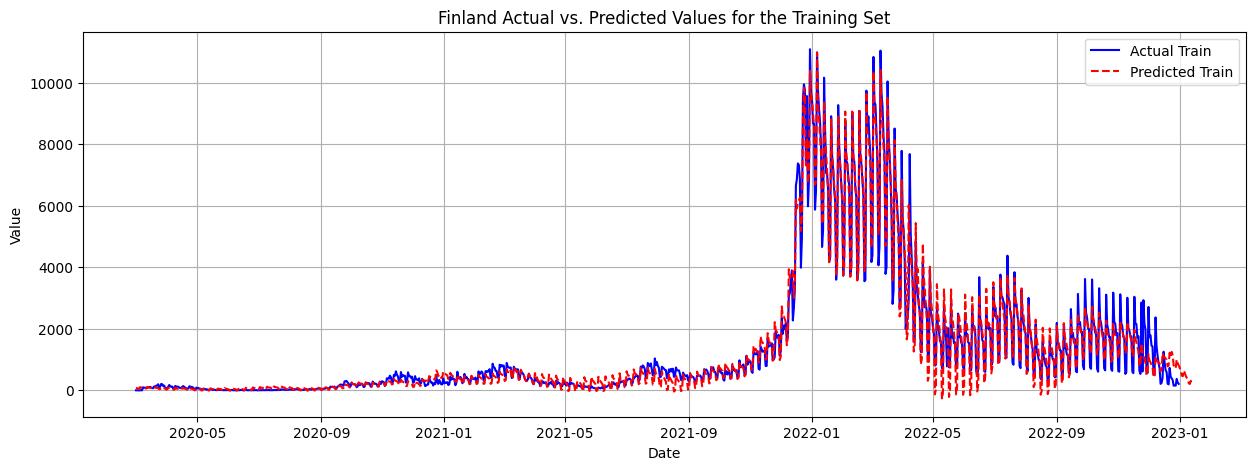

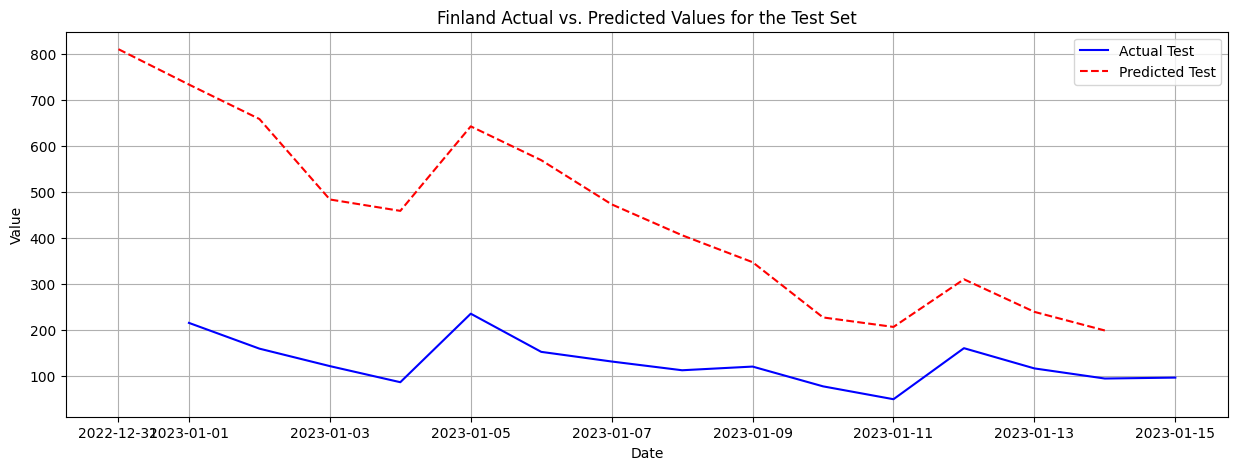

RMSE for the training set: 345.26228810717583
RMSE for the test set: 365.181852844884
sRMSE for the training set: 24.539739275812888
sRMSE for the test set: 282.64849291399696


In [378]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=finland_lockdowns, **finland_params, holidays_prior_scale = 2)
m.add_country_holidays(country_name='Finland')
m.fit(train_finland)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_finland['ds'] = pd.to_datetime(train_finland['ds'])
test_finland['ds'] = pd.to_datetime(test_finland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_finland['ds'], train_finland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Finland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_finland['ds'], test_finland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_finland)), forecast['yhat'].tail(len(test_finland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Finland Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_finland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_finland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_finland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_finland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 4. Ireland

#### Initial

15:39:29 - cmdstanpy - INFO - Chain [1] start processing
15:39:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/4004762146.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ireland['ds'] = pd.to_datetime(train_ireland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/4004762146.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ireland['ds'] = pd.to_datetime(test_ireland['ds'])


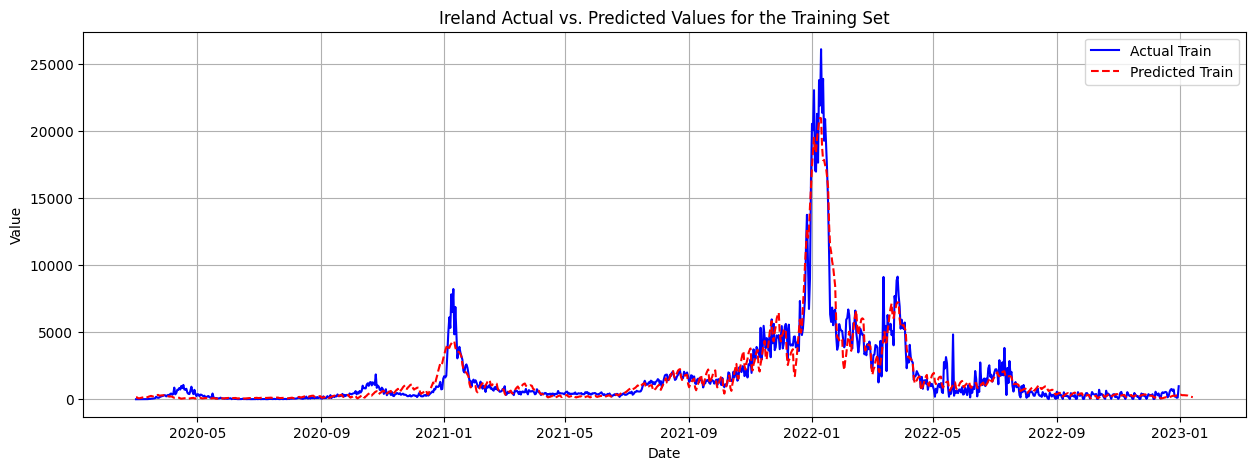

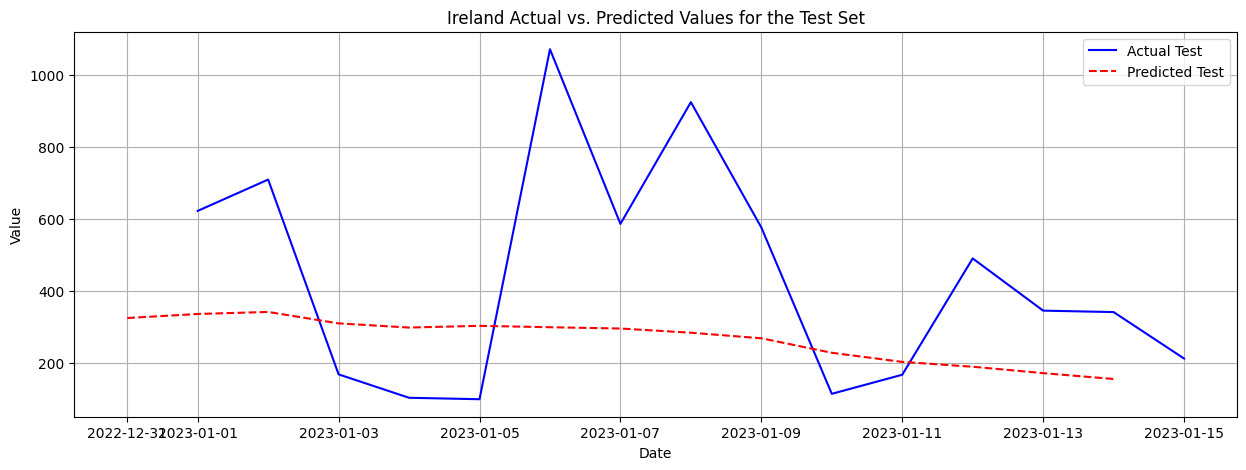

RMSE for the training set: 836.088305454395
RMSE for the test set: 332.63180534828115
sRMSE for the training set: 51.188696746660945
sRMSE for the test set: 76.44365068521859


In [379]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(**ireland_params)
# adding swiss holidays
m.fit(train_ireland)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_ireland['ds'] = pd.to_datetime(train_ireland['ds'])
test_ireland['ds'] = pd.to_datetime(test_ireland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_ireland['ds'], train_ireland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ireland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_ireland['ds'], test_ireland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_ireland)), forecast['yhat'].tail(len(test_ireland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ireland Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_ireland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_ireland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_ireland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_ireland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

initial_train_rmse.append(rmse_train)
initial_test_rmse.append(rmse_test)



#### Final

15:39:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/213278072.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ireland['ds'] = pd.to_datetime(train_ireland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/213278072.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ireland['ds'] = pd.to_datetime(test_ireland['ds'])


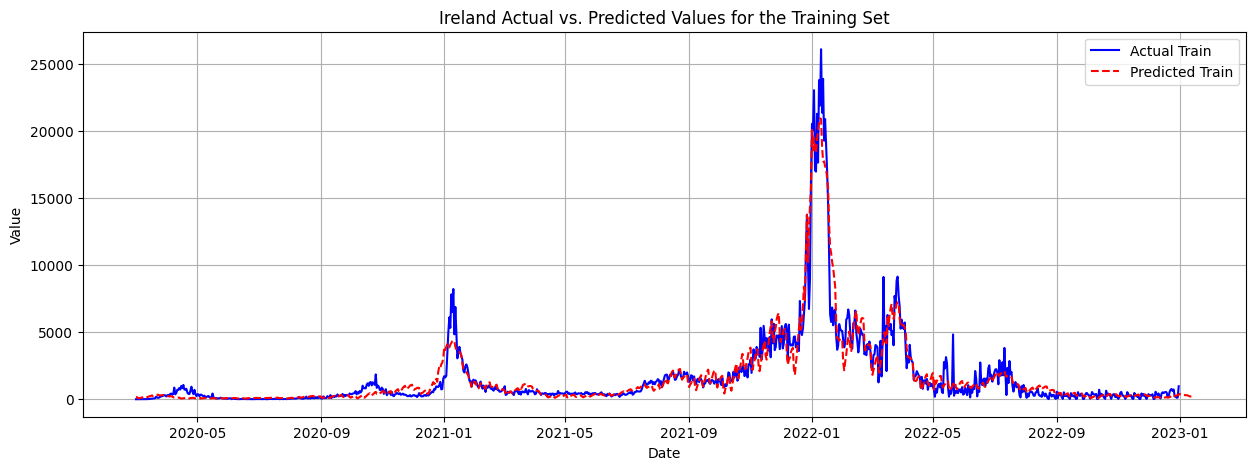

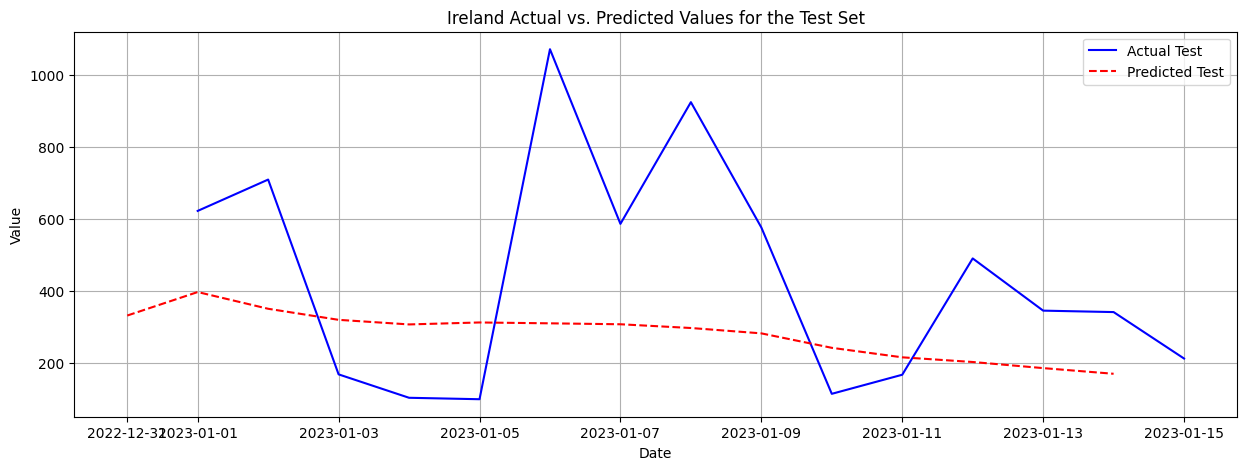

RMSE for the training set: 817.3661069253402
RMSE for the test set: 323.6602059002308
sRMSE for the training set: 50.04244827424185
sRMSE for the test set: 74.38184600127872


In [380]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=ireland_lockdowns, **ireland_params, holidays_prior_scale = 5)
m.add_country_holidays(country_name='Ireland')
m.fit(train_ireland)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_ireland['ds'] = pd.to_datetime(train_ireland['ds'])
test_ireland['ds'] = pd.to_datetime(test_ireland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_ireland['ds'], train_ireland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ireland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_ireland['ds'], test_ireland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_ireland)), forecast['yhat'].tail(len(test_ireland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ireland Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_ireland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_ireland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_ireland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_ireland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 5. Italy

#### Initial

15:39:31 - cmdstanpy - INFO - Chain [1] start processing
15:39:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/4003701760.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_italy['ds'] = pd.to_datetime(train_italy['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/4003701760.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_italy['ds'] = pd.to_datetime(test_italy['ds'])


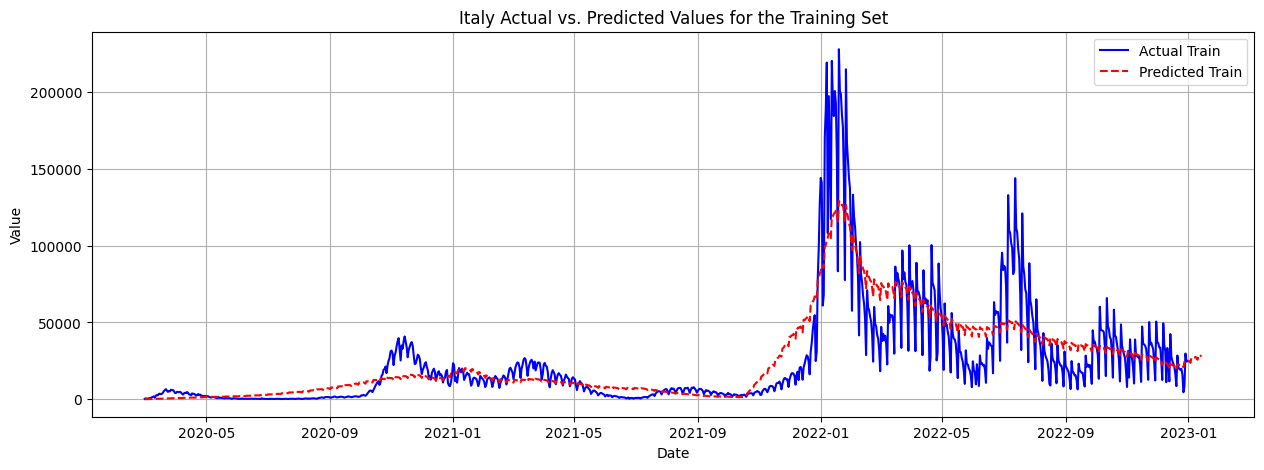

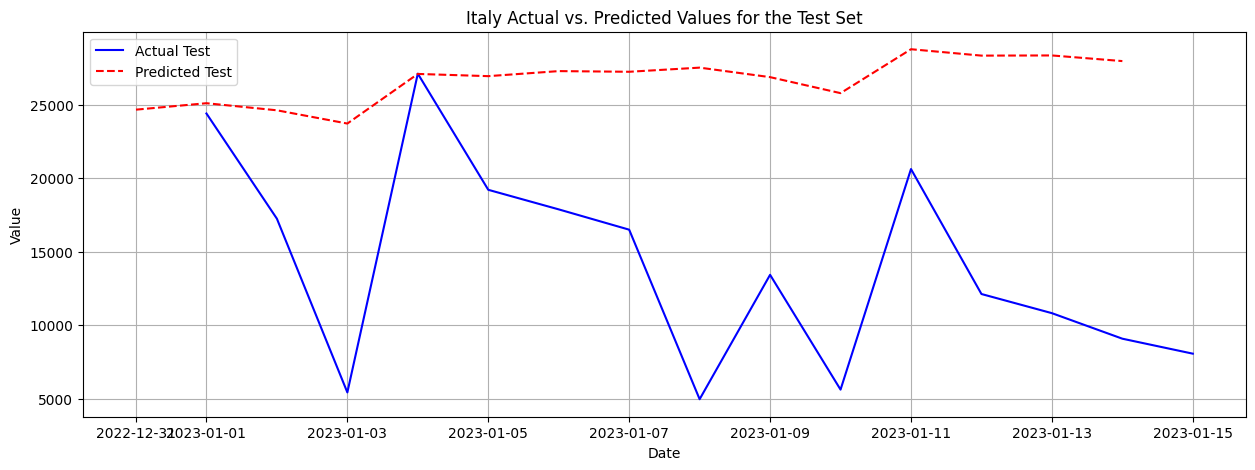

RMSE for the training set: 17928.69880991796
RMSE for the test set: 14659.79740107857
sRMSE for the training set: 73.80190748433999
sRMSE for the test set: 103.50527701396966


In [381]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(**italy_params)
# adding swiss holidays
m.fit(train_italy)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_italy['ds'] = pd.to_datetime(train_italy['ds'])
test_italy['ds'] = pd.to_datetime(test_italy['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_italy['ds'], train_italy['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Italy Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_italy['ds'], test_italy['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_italy)), forecast['yhat'].tail(len(test_italy)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Italy Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_italy['y'].values
predicted_train_values = forecast['yhat'].head(len(train_italy)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_italy['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_italy)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

initial_train_rmse.append(rmse_train)
initial_test_rmse.append(rmse_test)



#### Final

15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/343412350.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_italy['ds'] = pd.to_datetime(train_italy['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/343412350.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_italy['ds'] = pd.to_datetime(test_italy['ds'])


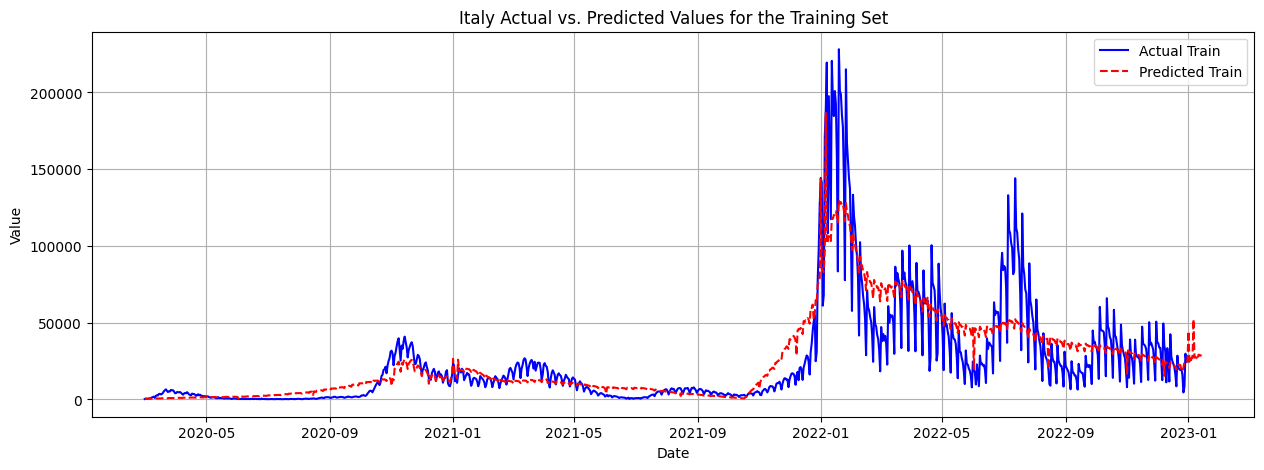

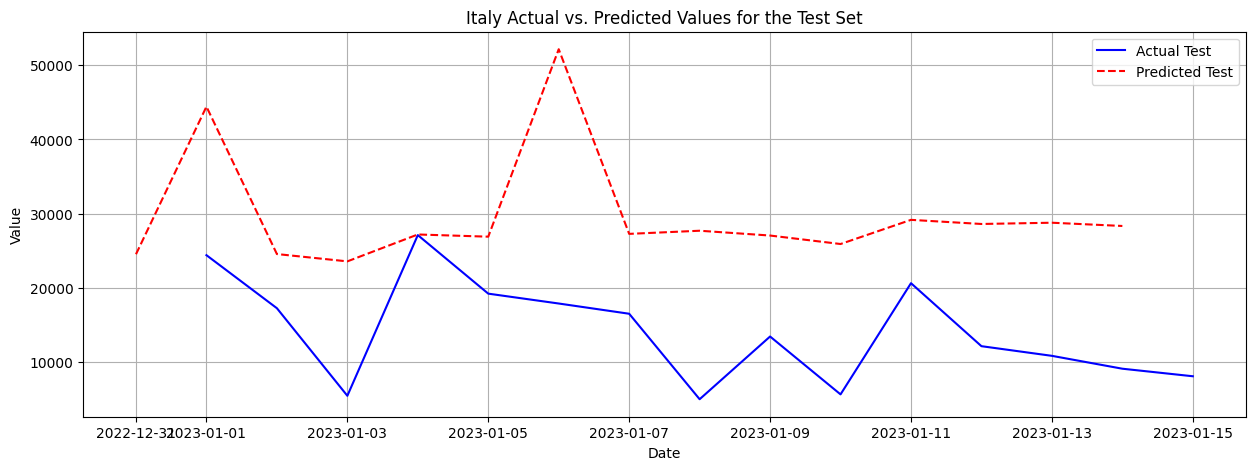

RMSE for the training set: 17263.763513591577
RMSE for the test set: 18488.452272065228
sRMSE for the training set: 71.06475997894461
sRMSE for the test set: 130.53743661142784


In [382]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=italy_lockdowns, **italy_params, holidays_prior_scale = 2)
m.add_country_holidays(country_name='Italy')
m.fit(train_italy)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_italy['ds'] = pd.to_datetime(train_italy['ds'])
test_italy['ds'] = pd.to_datetime(test_italy['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_italy['ds'], train_italy['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Italy Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_italy['ds'], test_italy['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_italy)), forecast['yhat'].tail(len(test_italy)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Italy Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_italy['y'].values
predicted_train_values = forecast['yhat'].head(len(train_italy)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_italy['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_italy)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 6. Lithuania

#### Initial

15:39:33 - cmdstanpy - INFO - Chain [1] start processing
15:39:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3979452364.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_lithuania['ds'] = pd.to_datetime(train_lithuania['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3979452364.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lithuania['ds'] = pd.to_datetime(test_lithuania['ds'])


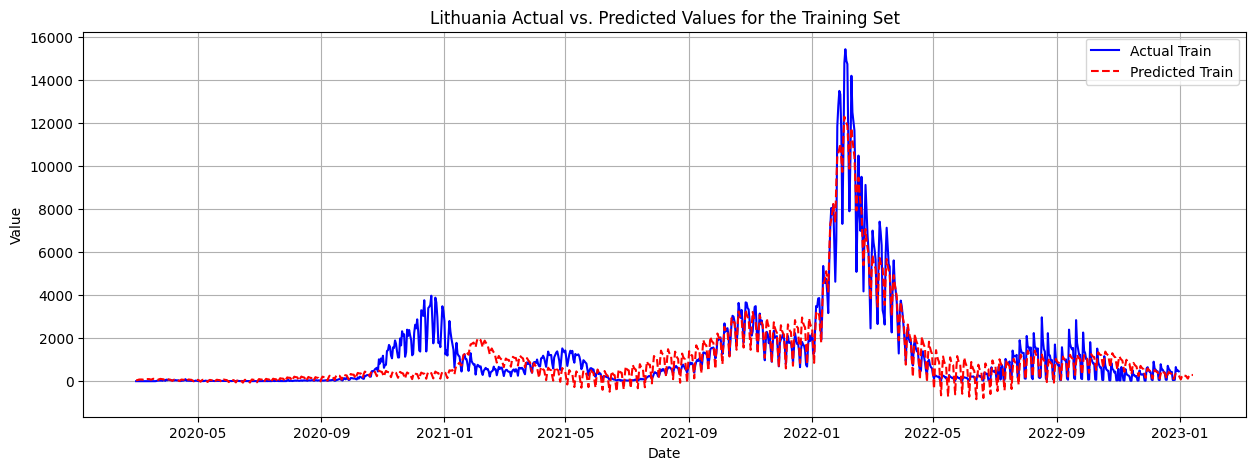

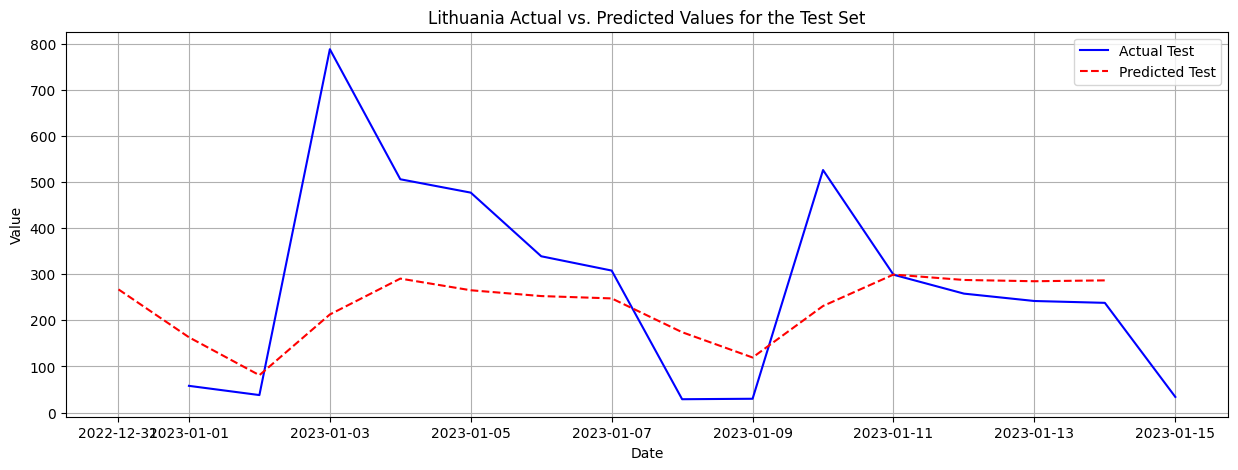

RMSE for the training set: 762.571922975193
RMSE for the test set: 257.7697867041901
sRMSE for the training set: 61.31721689029681
sRMSE for the test set: 92.72294485762234


In [383]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(**lithuania_params)
# adding swiss holidays
m.fit(train_lithuania)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_lithuania['ds'] = pd.to_datetime(train_lithuania['ds'])
test_lithuania['ds'] = pd.to_datetime(test_lithuania['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_lithuania['ds'], train_lithuania['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Lithuania Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_lithuania['ds'], test_lithuania['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_lithuania)), forecast['yhat'].tail(len(test_lithuania)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Lithuania Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_lithuania['y'].values
predicted_train_values = forecast['yhat'].head(len(train_lithuania)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_lithuania['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_lithuania)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

initial_train_rmse.append(rmse_train)
initial_test_rmse.append(rmse_test)



#### Final

15:39:34 - cmdstanpy - INFO - Chain [1] start processing
15:39:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3755062354.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_lithuania['ds'] = pd.to_datetime(train_lithuania['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3755062354.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lithuania['ds'] = pd.to_datetime(test_lithuania['ds'])


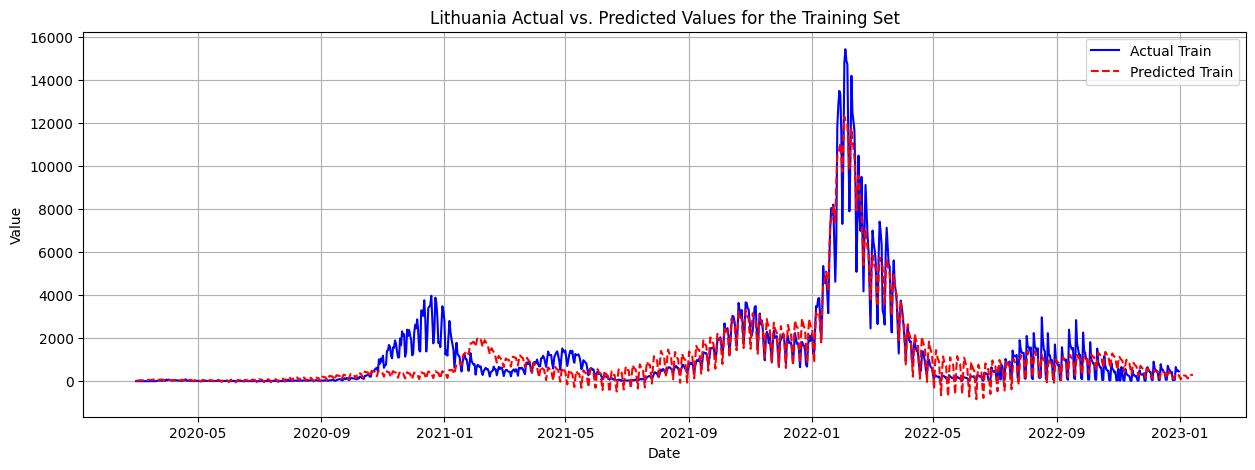

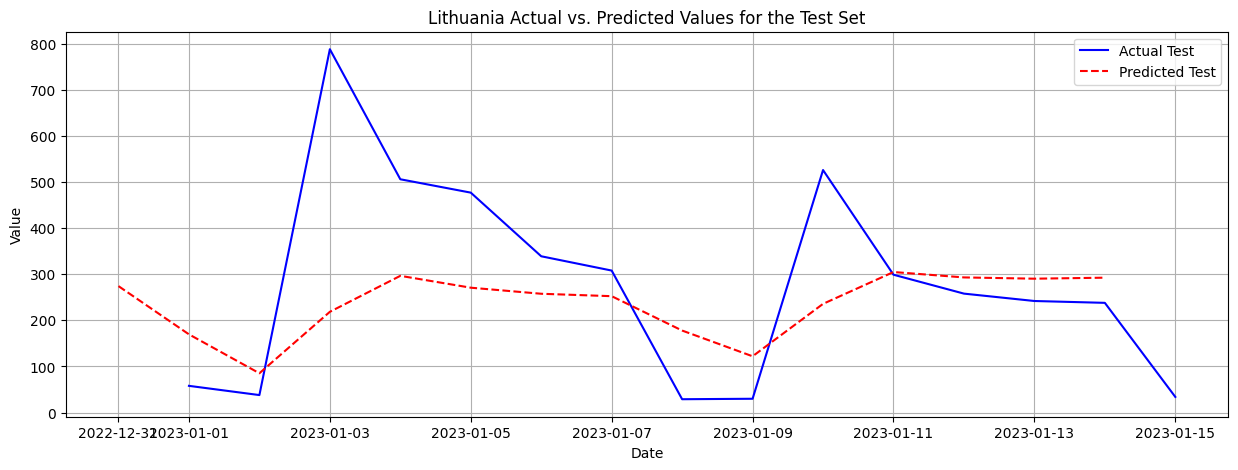

RMSE for the training set: 758.9580357835735
RMSE for the test set: 257.3666443372683
sRMSE for the training set: 61.02662986752648
sRMSE for the test set: 92.57792961772242


In [384]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=lithuania_lockdowns, **lithuania_params, holidays_prior_scale = 2)
m.add_country_holidays(country_name='Lithuania')
m.fit(train_lithuania)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_lithuania['ds'] = pd.to_datetime(train_lithuania['ds'])
test_lithuania['ds'] = pd.to_datetime(test_lithuania['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_lithuania['ds'], train_lithuania['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Lithuania Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_lithuania['ds'], test_lithuania['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_lithuania)), forecast['yhat'].tail(len(test_lithuania)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Lithuania Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_lithuania['y'].values
predicted_train_values = forecast['yhat'].head(len(train_lithuania)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_lithuania['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_lithuania)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 7. Norway

#### Initial

15:39:35 - cmdstanpy - INFO - Chain [1] start processing
15:39:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/4086927343.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_norway['ds'] = pd.to_datetime(train_norway['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/4086927343.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_norway['ds'] = pd.to_datetime(test_norway['ds'])


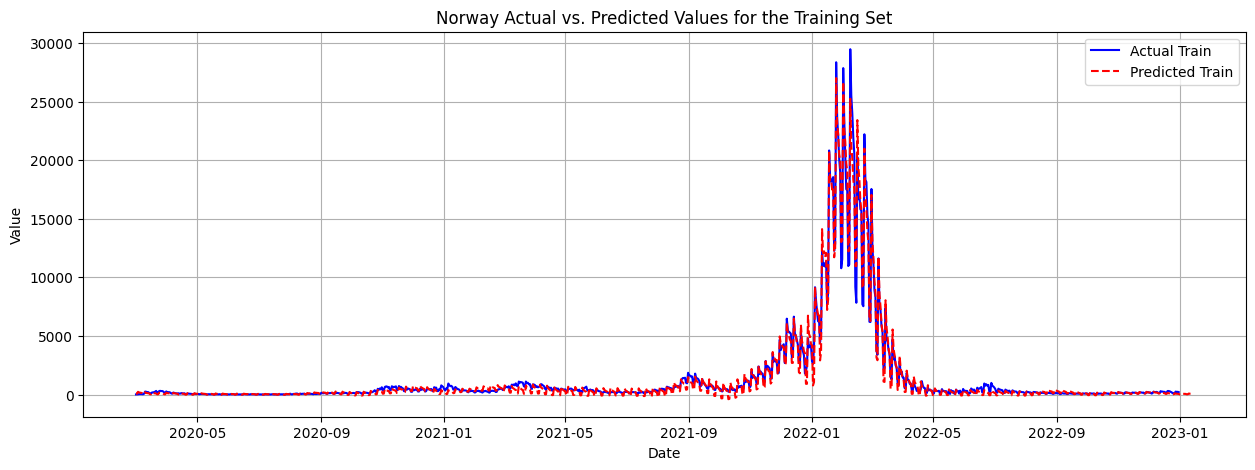

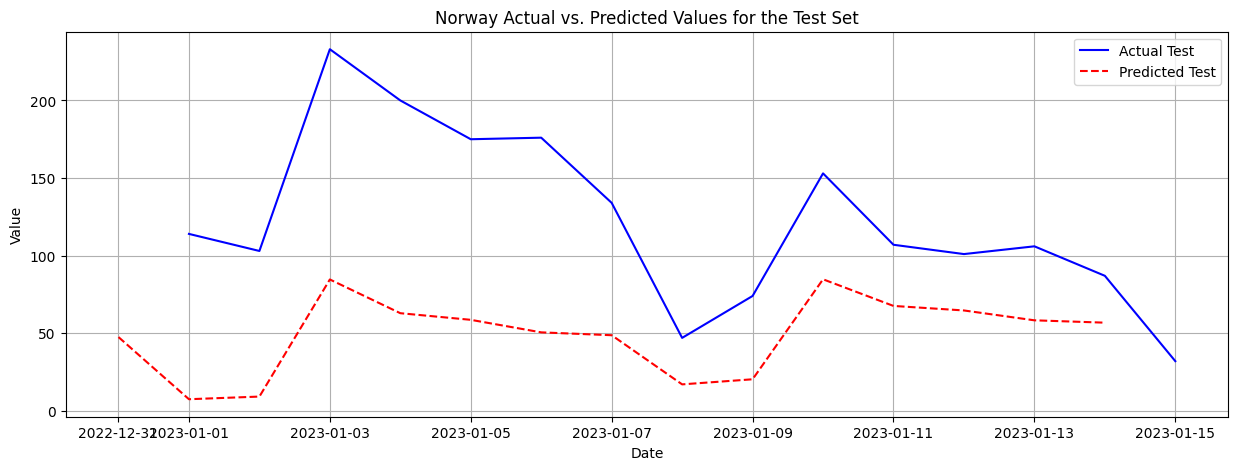

RMSE for the training set: 489.294815218117
RMSE for the test set: 95.16951458054729
sRMSE for the training set: 34.351463252002446
sRMSE for the test set: 77.49960470728607


In [385]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(**norway_params)
# adding swiss holidays
m.fit(train_norway)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_norway['ds'] = pd.to_datetime(train_norway['ds'])
test_norway['ds'] = pd.to_datetime(test_norway['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_norway['ds'], train_norway['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Norway Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_norway['ds'], test_norway['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_norway)), forecast['yhat'].tail(len(test_norway)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Norway Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_norway['y'].values
predicted_train_values = forecast['yhat'].head(len(train_norway)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_norway['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_norway)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

initial_train_rmse.append(rmse_train)
initial_test_rmse.append(rmse_test)



#### Final

15:39:36 - cmdstanpy - INFO - Chain [1] start processing
15:39:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3528745790.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_norway['ds'] = pd.to_datetime(train_norway['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3528745790.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_norway['ds'] = pd.to_datetime(test_norway['ds'])


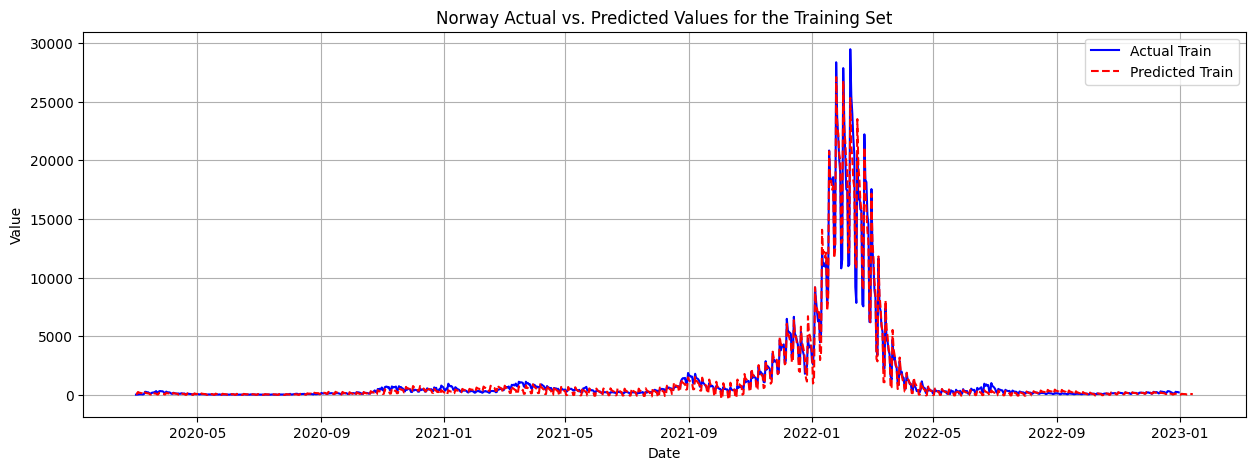

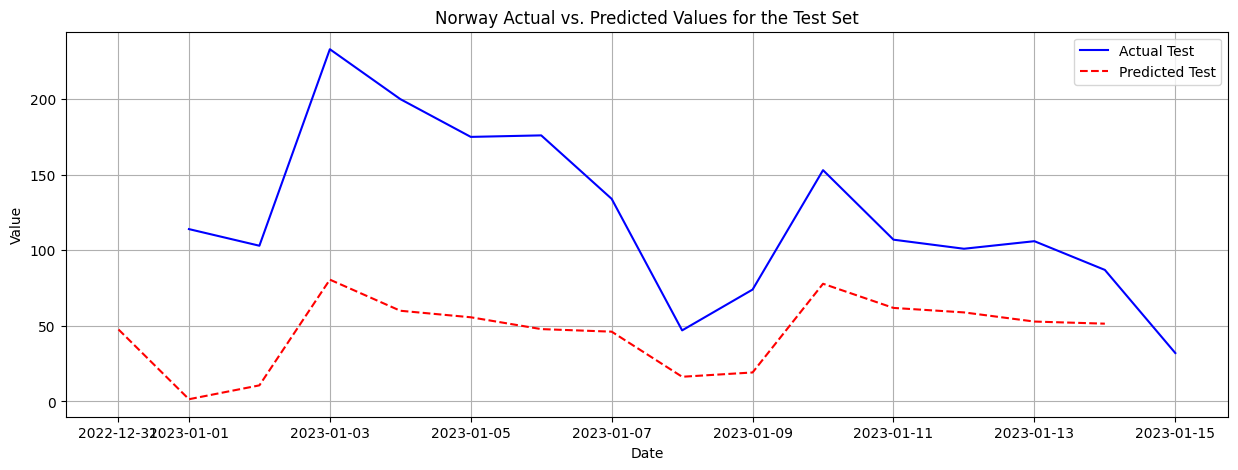

RMSE for the training set: 475.00990563143586
RMSE for the test set: 96.93825750786141
sRMSE for the training set: 33.34857597124042
sRMSE for the test set: 78.93994911063633


In [386]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=norway_lockdowns, **norway_params, holidays_prior_scale = 0.1)
m.add_country_holidays(country_name='Norway')
m.fit(train_norway)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_norway['ds'] = pd.to_datetime(train_norway['ds'])
test_norway['ds'] = pd.to_datetime(test_norway['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_norway['ds'], train_norway['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Norway Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_norway['ds'], test_norway['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_norway)), forecast['yhat'].tail(len(test_norway)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Norway Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_norway['y'].values
predicted_train_values = forecast['yhat'].head(len(train_norway)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_norway['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_norway)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 8. Poland

#### Initial

15:39:37 - cmdstanpy - INFO - Chain [1] start processing
15:39:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/384631819.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_poland['ds'] = pd.to_datetime(train_poland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/384631819.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_poland['ds'] = pd.to_datetime(test_poland['ds'])


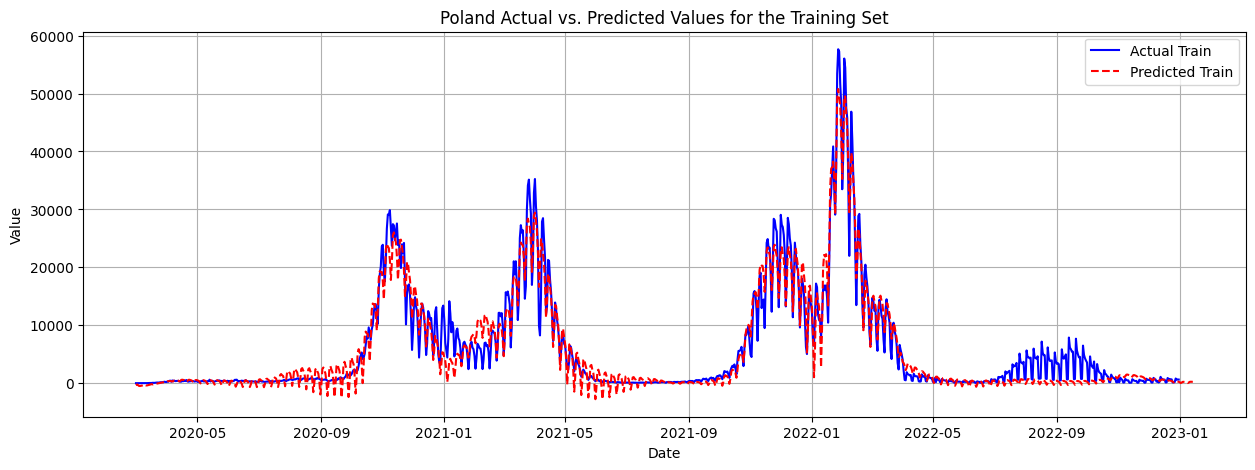

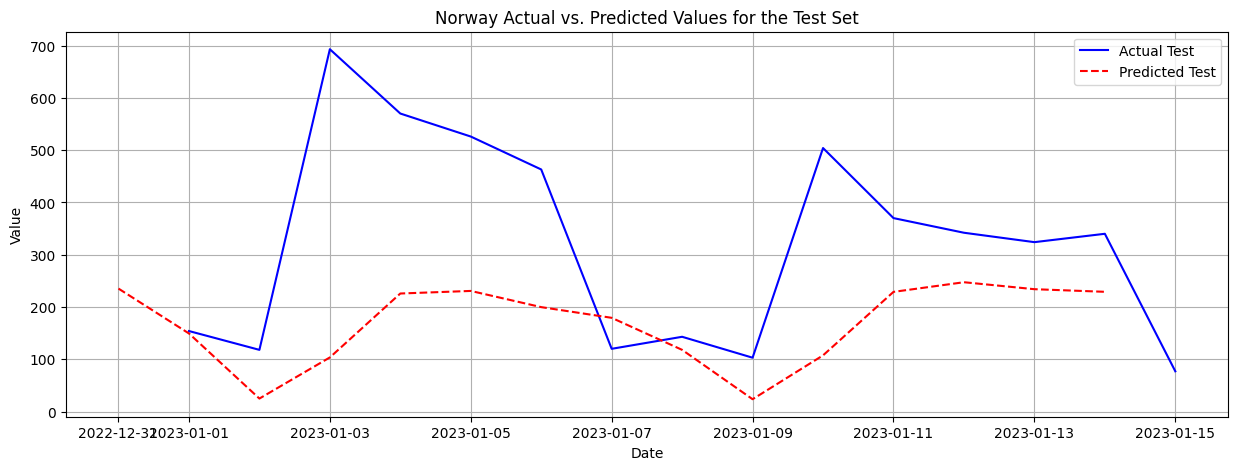

RMSE for the training set: 2391.303784162006
RMSE for the test set: 280.04022079605176
sRMSE for the training set: 38.901378502563574
sRMSE for the test set: 86.66398415392565


In [387]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(**poland_params)
# adding swiss holidays
m.fit(train_poland)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_poland['ds'] = pd.to_datetime(train_poland['ds'])
test_poland['ds'] = pd.to_datetime(test_poland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_poland['ds'], train_poland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Poland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_poland['ds'], test_poland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_poland)), forecast['yhat'].tail(len(test_poland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Norway Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_poland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_poland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_poland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_poland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

initial_train_rmse.append(rmse_train)
initial_test_rmse.append(rmse_test)



#### Final

15:39:38 - cmdstanpy - INFO - Chain [1] start processing
15:39:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3180193289.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_poland['ds'] = pd.to_datetime(train_poland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3180193289.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_poland['ds'] = pd.to_datetime(test_poland['ds'])


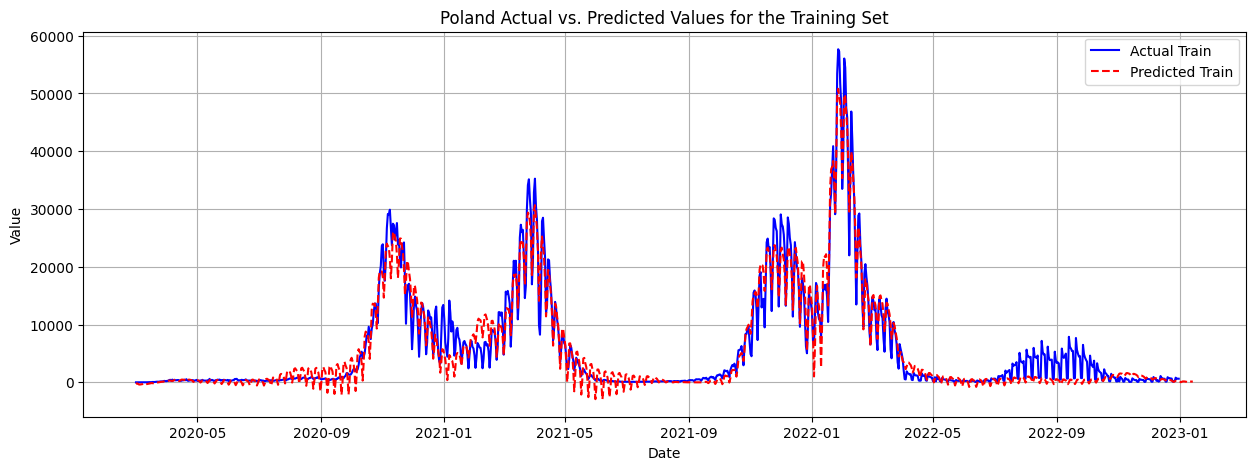

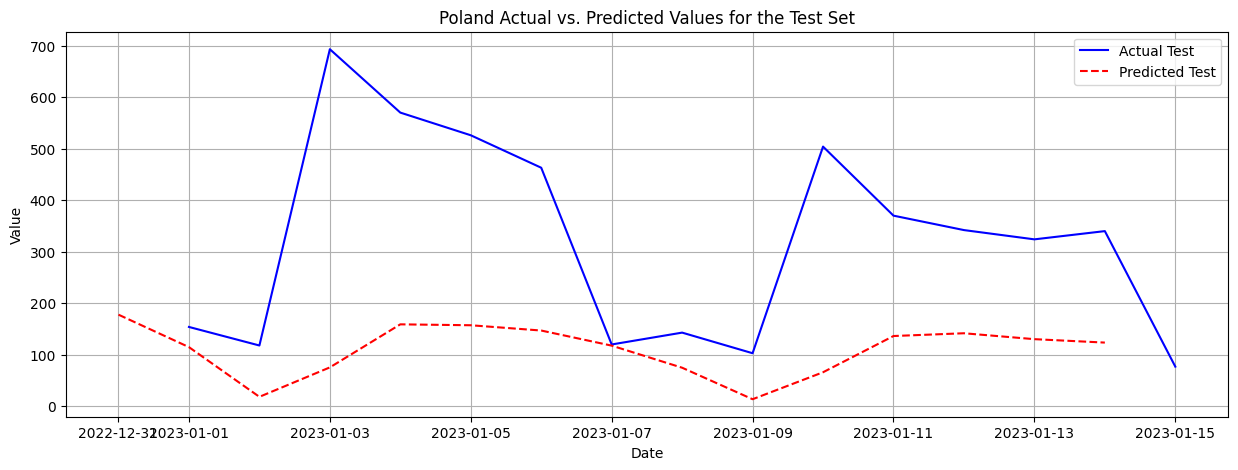

RMSE for the training set: 2296.462596460968
RMSE for the test set: 303.845395090674
sRMSE for the training set: 37.358516000180316
sRMSE for the test set: 94.03096608954219


In [388]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=poland_lockdowns, **poland_params, holidays_prior_scale = 0.1)
m.add_country_holidays(country_name='Poland')
m.fit(train_poland)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_poland['ds'] = pd.to_datetime(train_poland['ds'])
test_poland['ds'] = pd.to_datetime(test_poland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_poland['ds'], train_poland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Poland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_poland['ds'], test_poland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_poland)), forecast['yhat'].tail(len(test_poland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Poland Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_poland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_poland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_poland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_poland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 9. Switzerland

#### Initial

15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/4270800227.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_switzerland['ds'] = pd.to_datetime(train_switzerland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/4270800227.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_switzerland['ds'] = pd.to_datetime(test_switzerland['ds'])


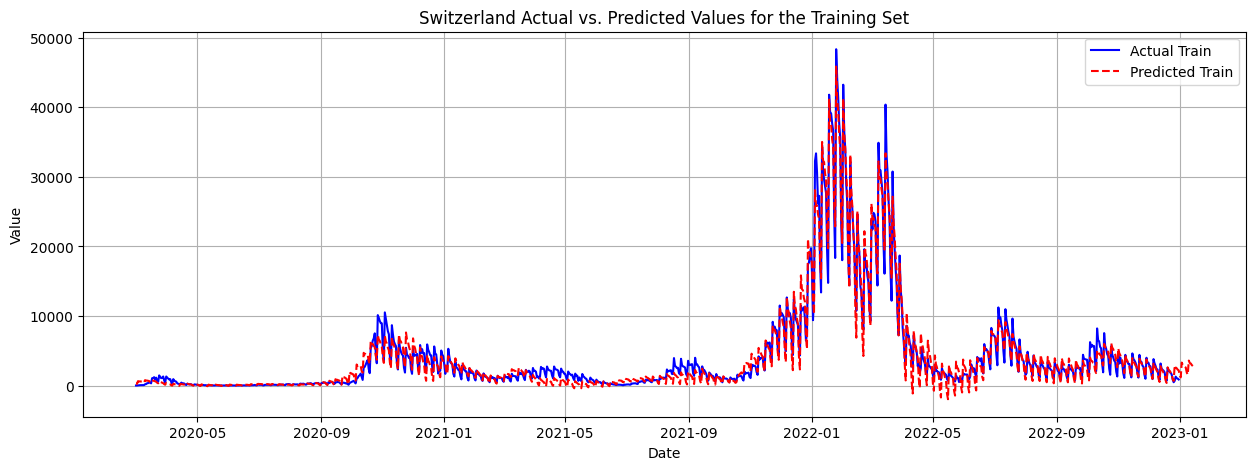

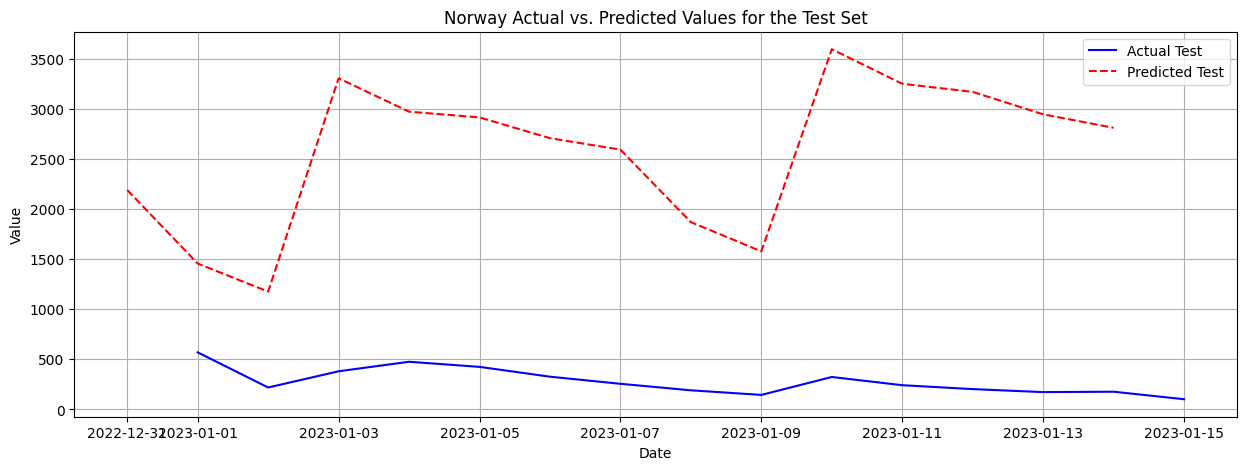

RMSE for the training set: 1139.6190160117212
RMSE for the test set: 2406.845925959293
sRMSE for the training set: 26.952719962673612
sRMSE for the test set: 857.3424101018614


In [389]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(**swiss_params)
# adding swiss holidays
m.fit(train_switzerland)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_switzerland['ds'] = pd.to_datetime(train_switzerland['ds'])
test_switzerland['ds'] = pd.to_datetime(test_switzerland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_switzerland['ds'], train_switzerland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Switzerland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_switzerland['ds'], test_switzerland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_switzerland)), forecast['yhat'].tail(len(test_switzerland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Norway Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_switzerland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_switzerland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_switzerland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_switzerland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

initial_train_rmse.append(rmse_train)
initial_test_rmse.append(rmse_test)



#### Final

15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/1801583085.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_switzerland['ds'] = pd.to_datetime(train_switzerland['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/1801583085.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_switzerland['ds'] = pd.to_datetime(test_switzerland['ds'])


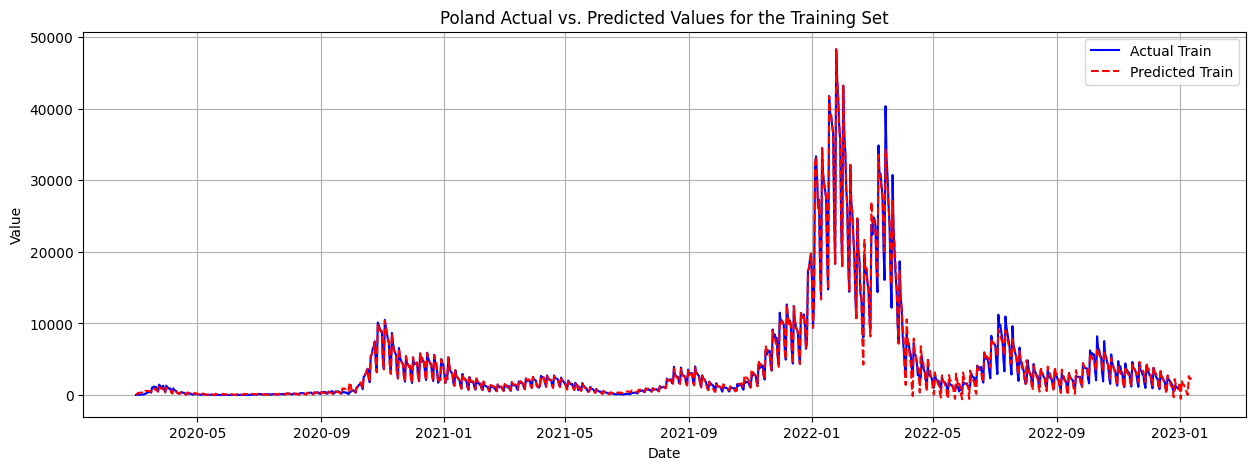

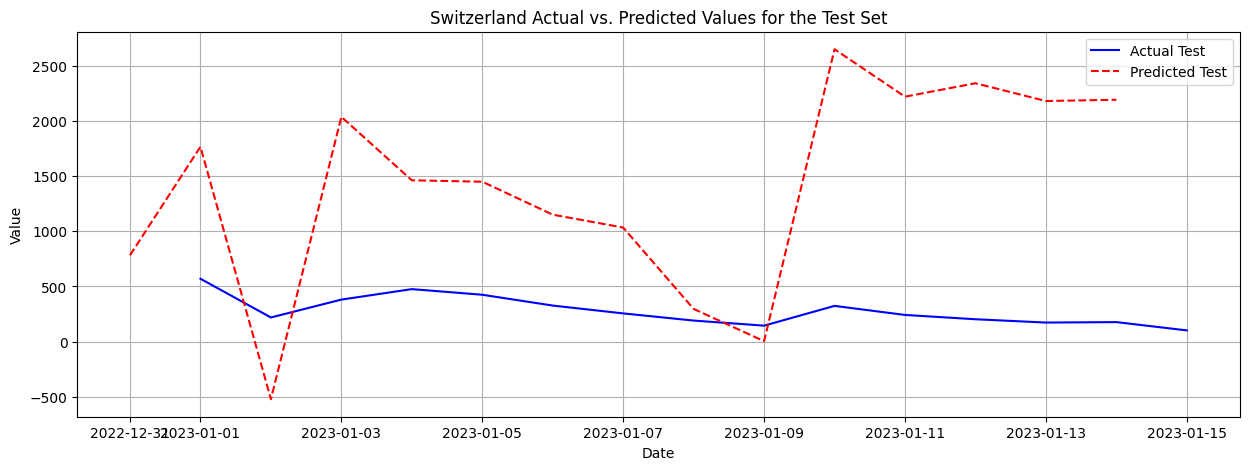

RMSE for the training set: 581.7721340211164
RMSE for the test set: 1474.7439471711434
sRMSE for the training set: 13.759283751892829
sRMSE for the test set: 525.3184328560235


In [390]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=swiss_lockdowns, **swiss_params, holidays_prior_scale = 2)
m.add_country_holidays(country_name='Switzerland')
m.fit(train_switzerland)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_switzerland['ds'] = pd.to_datetime(train_switzerland['ds'])
test_switzerland['ds'] = pd.to_datetime(test_switzerland['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_switzerland['ds'], train_switzerland['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Poland Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_switzerland['ds'], test_switzerland['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_switzerland)), forecast['yhat'].tail(len(test_switzerland)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Switzerland Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_switzerland['y'].values
predicted_train_values = forecast['yhat'].head(len(train_switzerland)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_switzerland['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_switzerland)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


### 10. United Kingdom

#### Initial

15:39:45 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3101613944.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_uk['ds'] = pd.to_datetime(train_uk['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/3101613944.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_uk['ds'] = pd.to_datetime(test_uk['ds'])


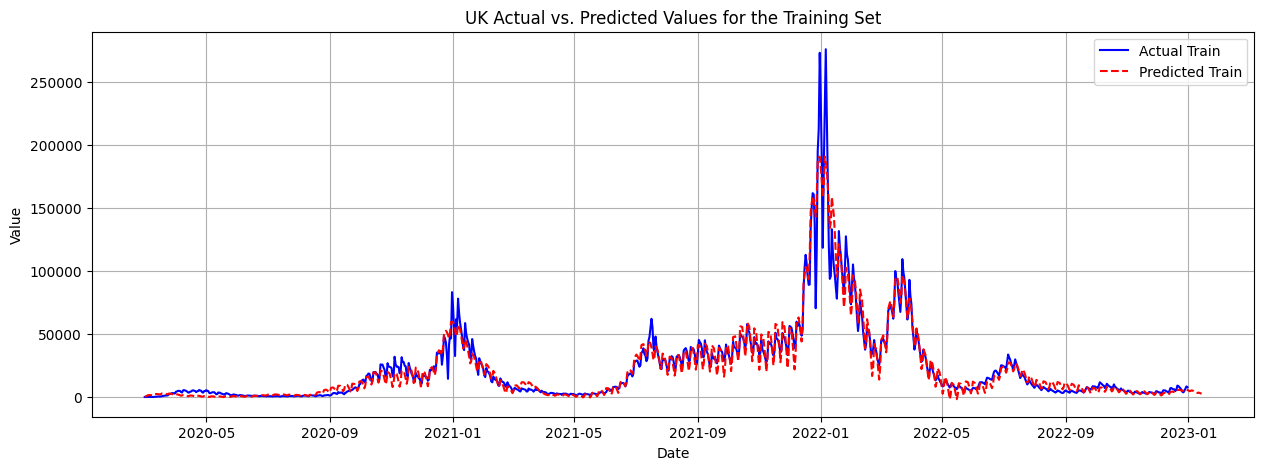

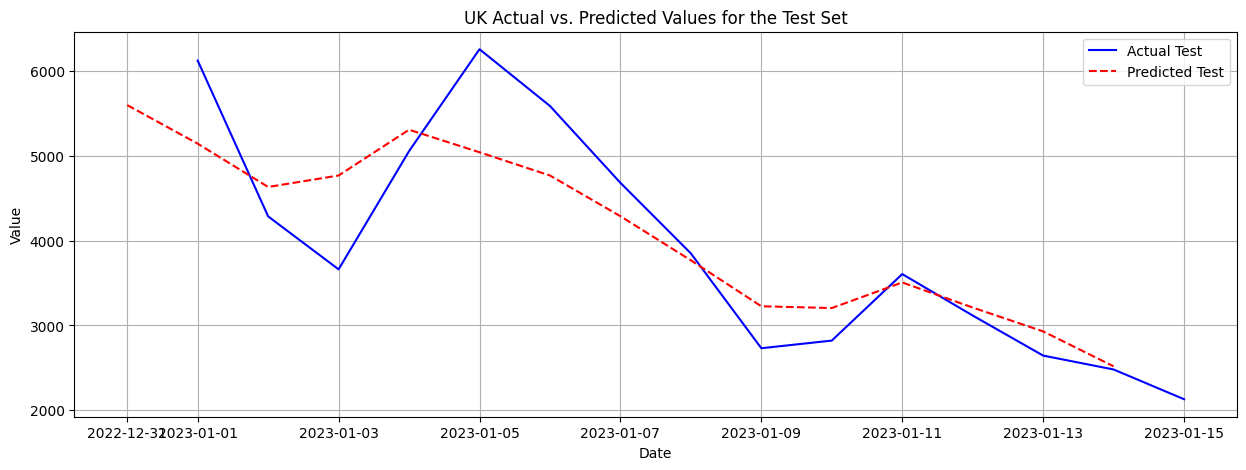

RMSE for the training set: 7890.062151318023
RMSE for the test set: 614.7879814733018
sRMSE for the training set: 33.784993003427566
sRMSE for the test set: 15.618819711226609


In [391]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(**uk_params)
# adding swiss holidays
m.fit(train_uk)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_uk['ds'] = pd.to_datetime(train_uk['ds'])
test_uk['ds'] = pd.to_datetime(test_uk['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_uk['ds'], train_uk['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('UK Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_uk['ds'], test_uk['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_uk)), forecast['yhat'].tail(len(test_uk)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('UK Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_uk['y'].values
predicted_train_values = forecast['yhat'].head(len(train_uk)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_uk['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_uk)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

initial_train_rmse.append(rmse_train)
initial_test_rmse.append(rmse_test)



#### Final

15:39:46 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/765428583.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_uk['ds'] = pd.to_datetime(train_uk['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_1003/765428583.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_uk['ds'] = pd.to_datetime(test_uk['ds'])


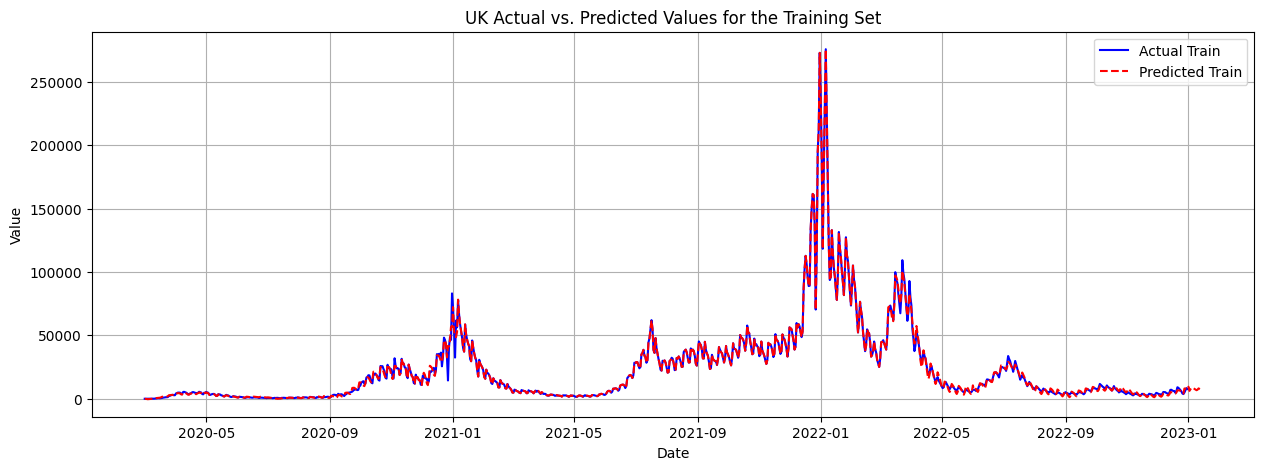

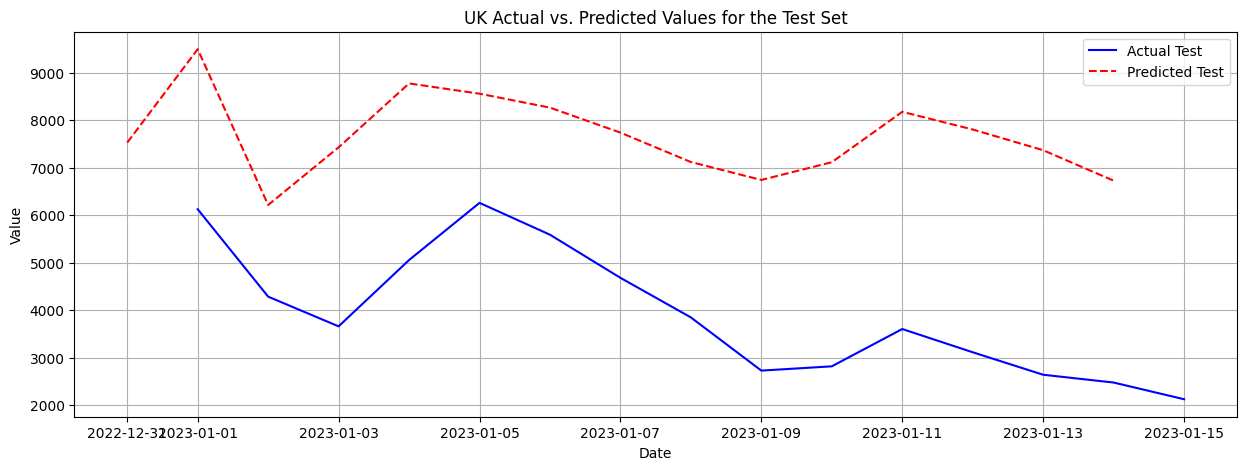

RMSE for the training set: 1859.9665065669094
RMSE for the test set: 3902.53263423148
sRMSE for the training set: 7.964316909781946
sRMSE for the test set: 99.14467339646056


In [392]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays=uk_lockdowns, **uk_params, holidays_prior_scale = 2)
m.add_country_holidays(country_name='GB')
m.fit(train_uk)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = forecast.set_index('ds')

# Assuming 'ds' is a string representing dates, convert it to datetime
train_uk['ds'] = pd.to_datetime(train_uk['ds'])
test_uk['ds'] = pd.to_datetime(test_uk['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_uk['ds'], train_uk['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('UK Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_uk['ds'], test_uk['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test_uk)), forecast['yhat'].tail(len(test_uk)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('UK Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()

# Extract the actual and forecasted values for the training set
actual_train_values = train_uk['y'].values
predicted_train_values = forecast['yhat'].head(len(train_uk)).values

# Calculate RMSE and sRMSE for the training set
rmse_train = np.sqrt(mean_squared_error(actual_train_values, predicted_train_values))
srmse_train = rmse_train / np.mean(actual_train_values) * 100

# Extract the actual and forecasted values for the test set
actual_test_values = test_uk['y'].values
predicted_test_values = forecast['yhat'].tail(len(test_uk)).values

# Calculate RMSE and sRMSE for the test set
rmse_test = np.sqrt(mean_squared_error(actual_test_values, predicted_test_values))
srmse_test = rmse_test / np.mean(actual_test_values) * 100
print(f"RMSE for the training set: {rmse_train}")
print(f"RMSE for the test set: {rmse_test}")
print(f"sRMSE for the training set: {srmse_train}")
print(f"sRMSE for the test set: {srmse_test}")

final_train_rmse.append(rmse_train)
final_test_rmse.append(rmse_test)
standardized_rmse.append(srmse_test)


In [393]:
initial_train_rmse

[4110.32682815228,
 1293.3945624541166,
 365.0780786672954,
 836.088305454395,
 17928.69880991796,
 762.571922975193,
 489.294815218117,
 2391.303784162006,
 1139.6190160117212,
 7890.062151318023]

In [2]:
initial_results = pd.DataFrame({
    'Location': country_names,
    'Train RMSE': initial_train_rmse,
    'Test RMSE' : initial_test_rmse,
})

NameError: name 'pd' is not defined

In [394]:
# Results
results_table = pd.DataFrame({
    'Location': country_names,
    'Initial Train RMSE': initial_train_rmse,
    'Initial Test RMSE': initial_test_rmse,
    'Final Train RMSE': final_train_rmse,
    'Final Test RMSE': final_test_rmse,
    'Standardized RMSE': standardized_rmse,
})
results_table

,Location,Initial Train RMSE,Initial Test RMSE,Final Train RMSE,Final Test RMSE,Standardized RMSE
0,Belgium,4110.326828,301.182961,3371.176369,284.482069,48.969831
1,Denmark,1293.394562,448.429506,1280.049789,456.141243,80.704395
2,Finland,365.078079,447.191755,345.262288,365.181853,282.648493
3,Ireland,836.088305,332.631805,817.366107,323.660206,74.381846
4,Italy,17928.698810,14659.797401,17263.763514,18488.452272,130.537437
5,Lithuania,762.571923,257.769787,758.958036,257.366644,92.577930
6,Norway,489.294815,95.169515,475.009906,96.938258,78.939949
7,Poland,2391.303784,280.040221,2296.462596,303.845395,94.030966
8,Switzerland,1139.619016,2406.845926,581.772134,1474.743947,525.318433
9,United Kingdom,7890.062151,614.787981,1859.966507,3902.532634,99.144673


For Belgium, Finland, Ireland, and Switzerland, adding in holiday and lockdown effects seems to improve the RMSE.

For the other countries, they do not. We will proceed accordingly when adding multiple regressors.